In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from models import WorldModel
from dataset import create_wall_dataloader
import seaborn as sns
from tqdm import tqdm

In [7]:
# Set Matplotlib style for better visualizations
# plt.style.use('seaborn')

def load_model_and_data():
    """Load the trained model and test datasets"""
 
    model = WorldModel(loss_type='both')
    checkpoint = torch.load('checkpoints/baseline_combined_lr_reduced/checkpoint_epoch_87.pt')
    model.load_state_dict(checkpoint['model_state_dict'])
    model.cuda()
    model.eval()
    
    # Load different test datasets
    datasets = {}
    for dataset_name in ['normal', 'wall', 'wall_other']:
        datasets[dataset_name] = create_wall_dataloader(
            data_path=f'/drive_reader/as16386/DL24FA/probe_{dataset_name}/val',
            probing=True,
            device='cuda',
            batch_size=32,
            train=False
        )
    
    return model, datasets

def visualize_conv_filters(model, layer_idx=0):
    """Visualize convolutional filters from the encoder"""
    # Get the first convolutional layer
    conv_layer = model.encoder.conv1 if layer_idx == 0 else model.encoder.conv2
    
    # Get the weights and normalize them for visualization
    weights = conv_layer.weight.data.cpu()
    weights = (weights - weights.min()) / (weights.max() - weights.min())
    
    # Create a grid of filter visualizations
    n_filters = weights.shape[0]
    n_channels = weights.shape[1]
    n_rows = int(np.sqrt(n_filters))
    n_cols = int(np.ceil(n_filters / n_rows))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15))
    axes = axes.flatten()
    
    for i in range(n_filters):
        # Average across input channels for visualization
        filter_img = weights[i].mean(dim=0)
        axes[i].imshow(filter_img, cmap='viridis')
        axes[i].axis('off')
        axes[i].set_title(f'Filter {i+1}')
    
    plt.suptitle(f'Convolutional Filters - Layer {layer_idx+1}', size=16)
    plt.tight_layout()
    return fig

def compute_feature_maps(model, sample_batch):
    """Compute and visualize feature maps for a sample input"""
    # Get initial state
    init_state = sample_batch.states[:1, 0:1]  # Take first sample
    
    # Register hooks to get intermediate activations
    activations = {}
    
    def get_activation(name):
        def hook(model, input, output):
            activations[name] = output.detach()
        return hook
    
    model.encoder.conv1.register_forward_hook(get_activation('conv1'))
    model.encoder.conv2.register_forward_hook(get_activation('conv2'))
    
    # Forward pass
    with torch.no_grad():
        _ = model(states=init_state, actions=sample_batch.actions[:1])
    
    return activations, init_state

def visualize_feature_maps(activations, input_state):
    """Visualize feature maps from different layers"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Plot input
    axes[0,0].imshow(input_state[0,0,0].cpu(), cmap='gray')
    axes[0,0].set_title('Input - Agent Channel')
    axes[0,1].imshow(input_state[0,0,1].cpu(), cmap='gray')
    axes[0,1].set_title('Input - Wall Channel')
    axes[0,2].axis('off')
    
    # Plot sample feature maps from each conv layer
    for idx, (name, feats) in enumerate(activations.items()):
        # Take first sample feature maps
        feature_maps = feats[0].cpu()
        
        # Show average activation
        avg_activation = feature_maps.mean(dim=0)
        axes[1,idx].imshow(avg_activation, cmap='viridis')
        axes[1,idx].set_title(f'{name} Avg Activation')
    
    plt.tight_layout()
    return fig

def analyze_predictions(model, dataset, num_samples=5):
    """Analyze predicted vs actual locations for a few samples"""
    predictions = []
    targets = []
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(dataset):
            if batch_idx >= num_samples:
                break
                
            # Get initial state and full sequence
            init_states = batch.states[:, 0:1]
            pred_encs = model(states=init_states, actions=batch.actions)
            
            # Store predictions and targets
            predictions.append(pred_encs.cpu().numpy())
            targets.append(batch.locations.cpu().numpy())
    
    return np.concatenate(predictions), np.concatenate(targets)

def plot_trajectory_comparison(predictions, targets, sample_idx=0):
    """Plot predicted vs actual trajectories for a single sample"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot x-coordinates over time
    ax1.plot(targets[sample_idx, :, 0], label='Actual', marker='o')
    ax1.plot(predictions[sample_idx, :, 0], label='Predicted', marker='x')
    ax1.set_title('X-coordinate over time')
    ax1.set_xlabel('Time step')
    ax1.set_ylabel('X position')
    ax1.legend()
    
    # Plot y-coordinates over time
    ax2.plot(targets[sample_idx, :, 1], label='Actual', marker='o')
    ax2.plot(predictions[sample_idx, :, 1], label='Predicted', marker='x')
    ax2.set_title('Y-coordinate over time')
    ax2.set_xlabel('Time step')
    ax2.set_ylabel('Y position')
    ax2.legend()
    
    plt.tight_layout()
    return fig

def compute_prediction_errors(predictions, targets):
    """Compute prediction errors over time"""
    mse_over_time = np.mean((predictions - targets) ** 2, axis=(0, 2))
    return mse_over_time

def plot_error_analysis(mse_over_time, dataset_name):
    """Plot error analysis"""
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(mse_over_time, marker='o')
    ax.set_title(f'MSE over time - {dataset_name} dataset')
    ax.set_xlabel('Time step')
    ax.set_ylabel('Mean Squared Error')
    ax.grid(True)
    return fig


Loading model and datasets...

Visualizing convolutional filters...


/tmp/ipykernel_3429410/3038372815.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('checkpoints/baseline_combined_lr_reduced/checkpoint_epoch_87.p


Analyzing feature maps...

Analyzing predictions for each dataset...

Processing normal dataset...


ValueError: operands could not be broadcast together with shapes (160,17,2048) (160,17,2) 

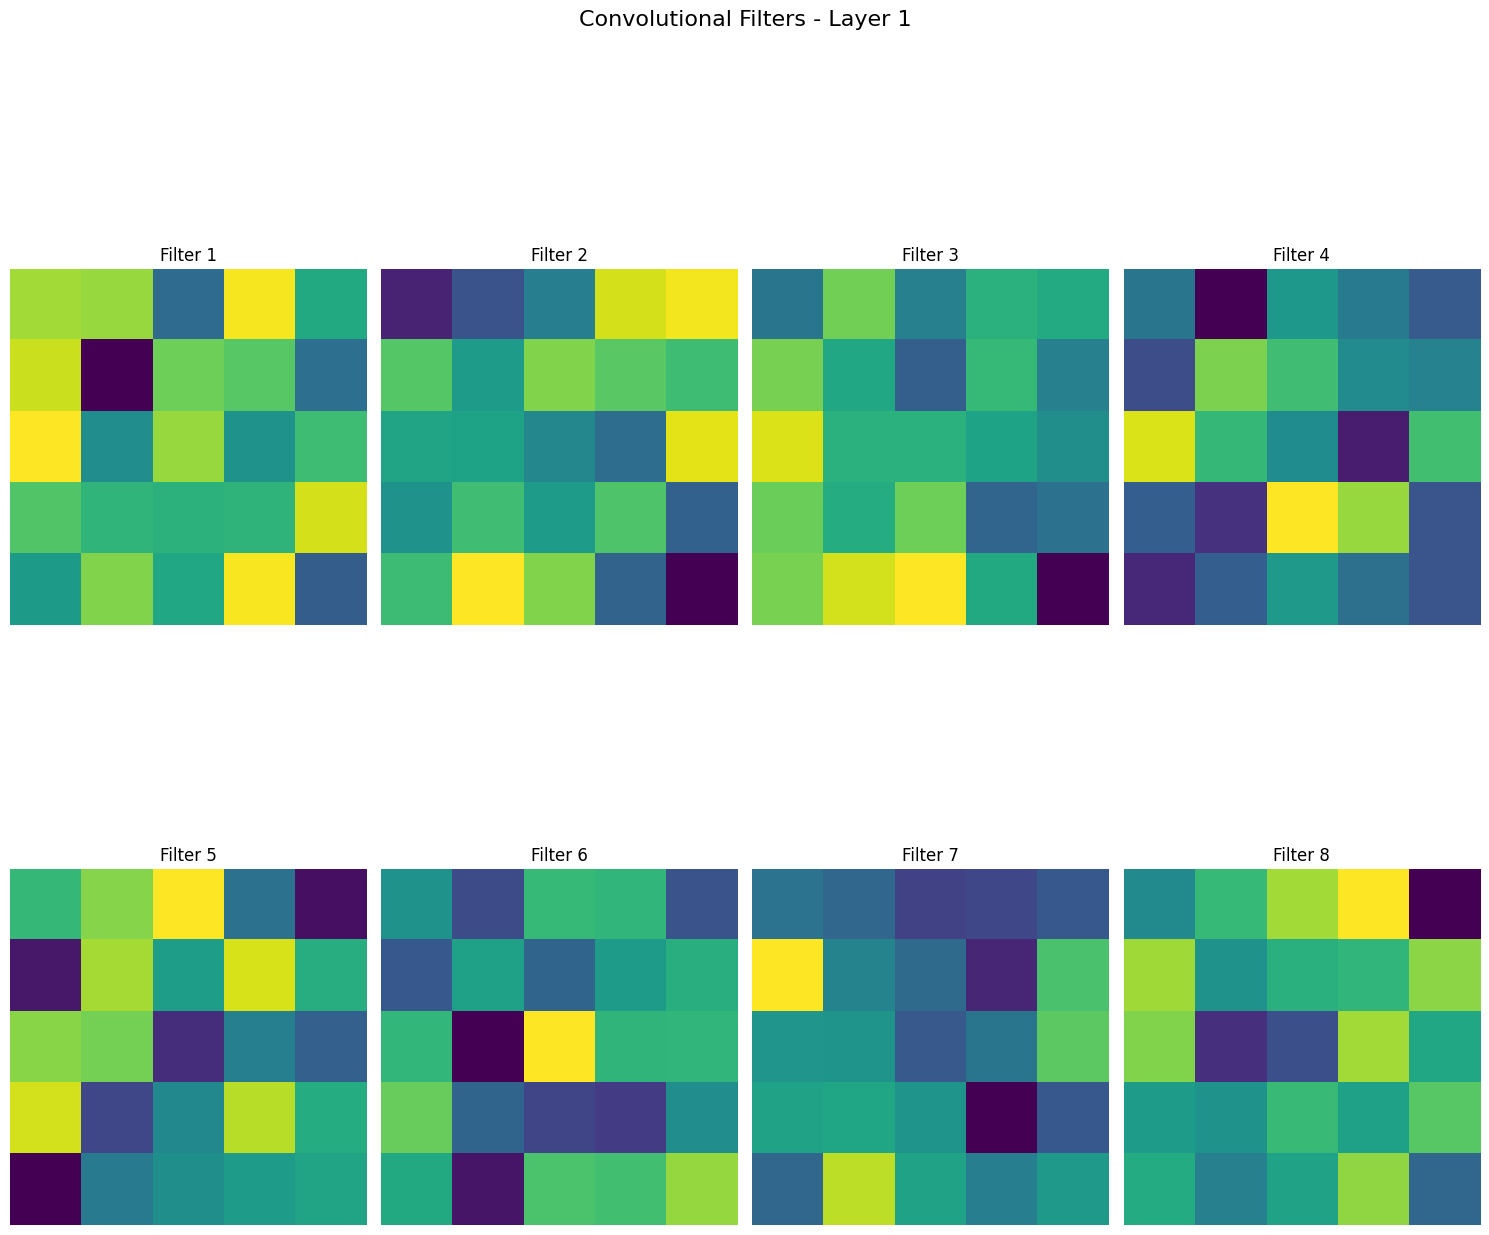

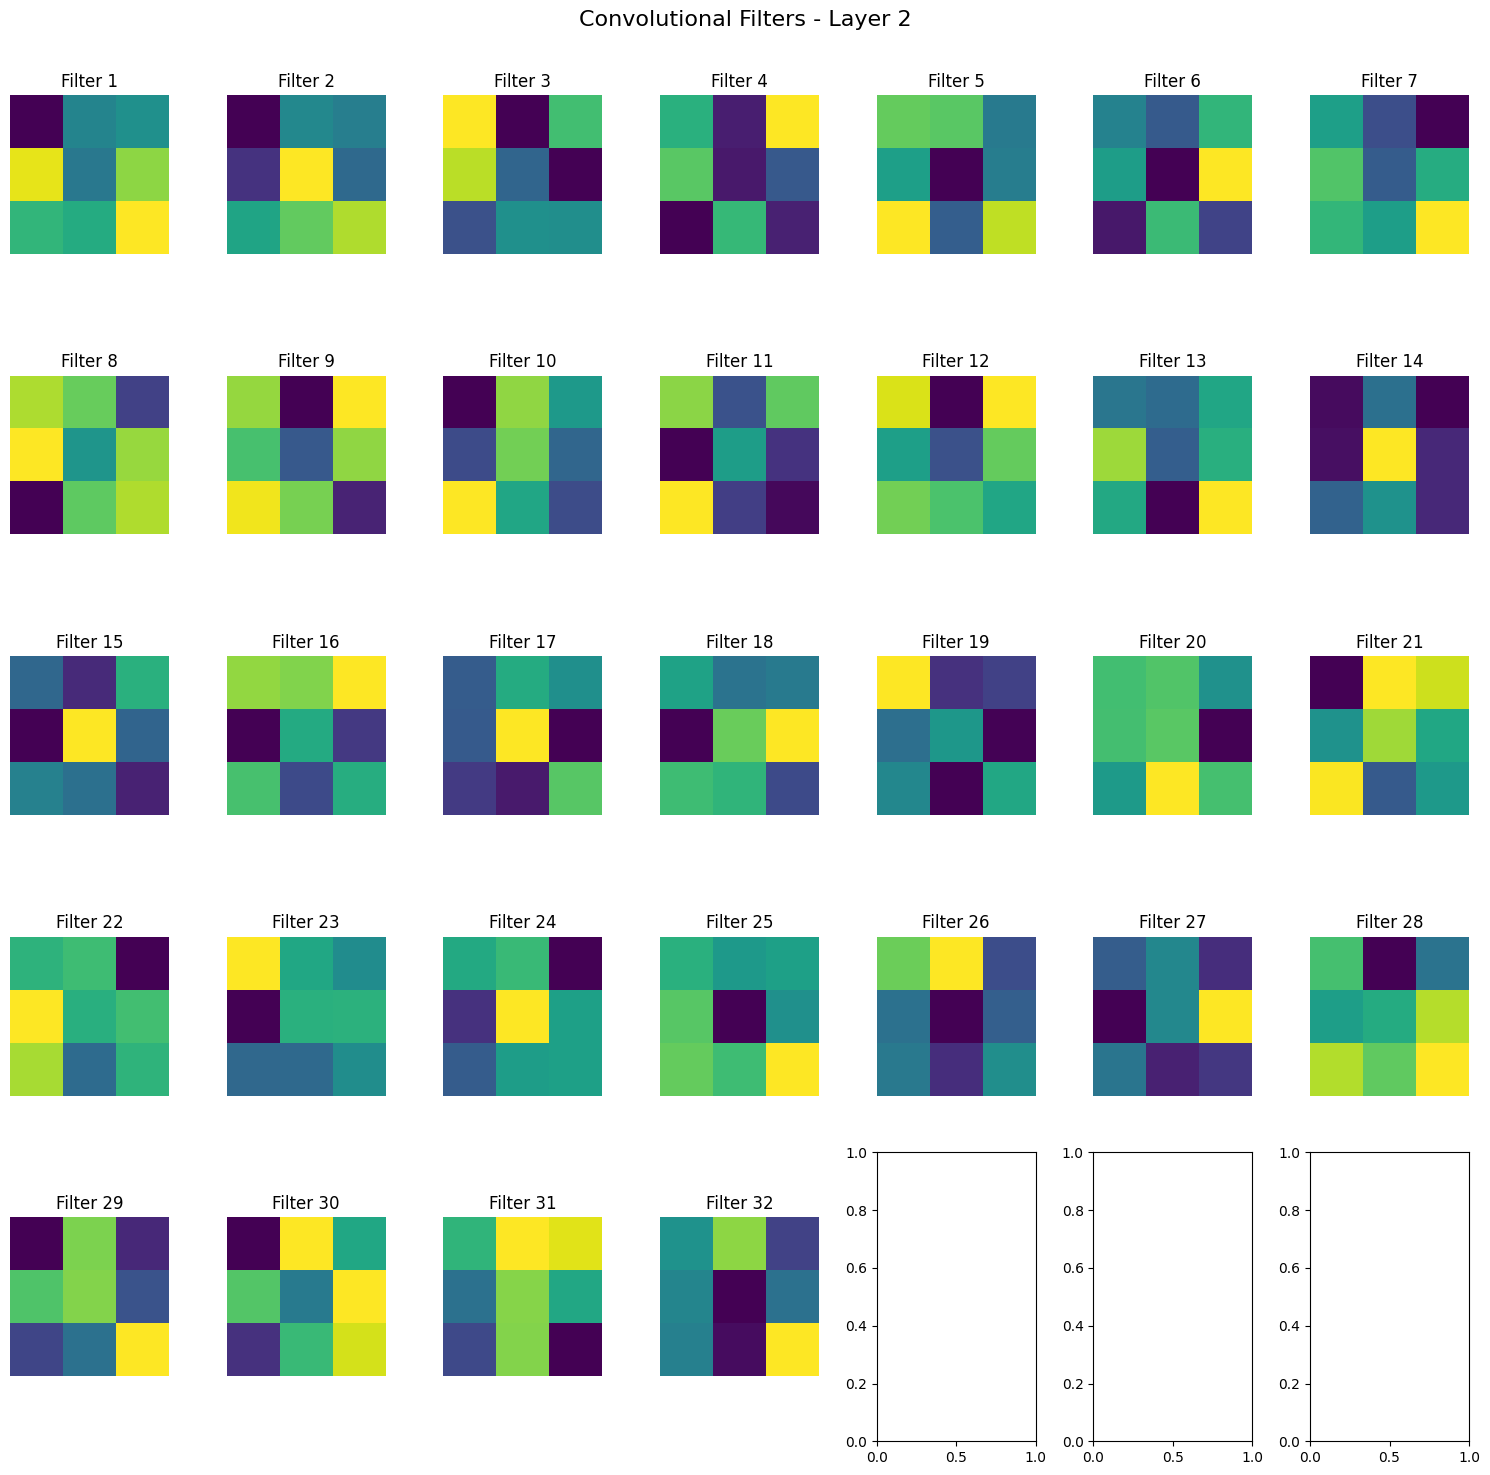

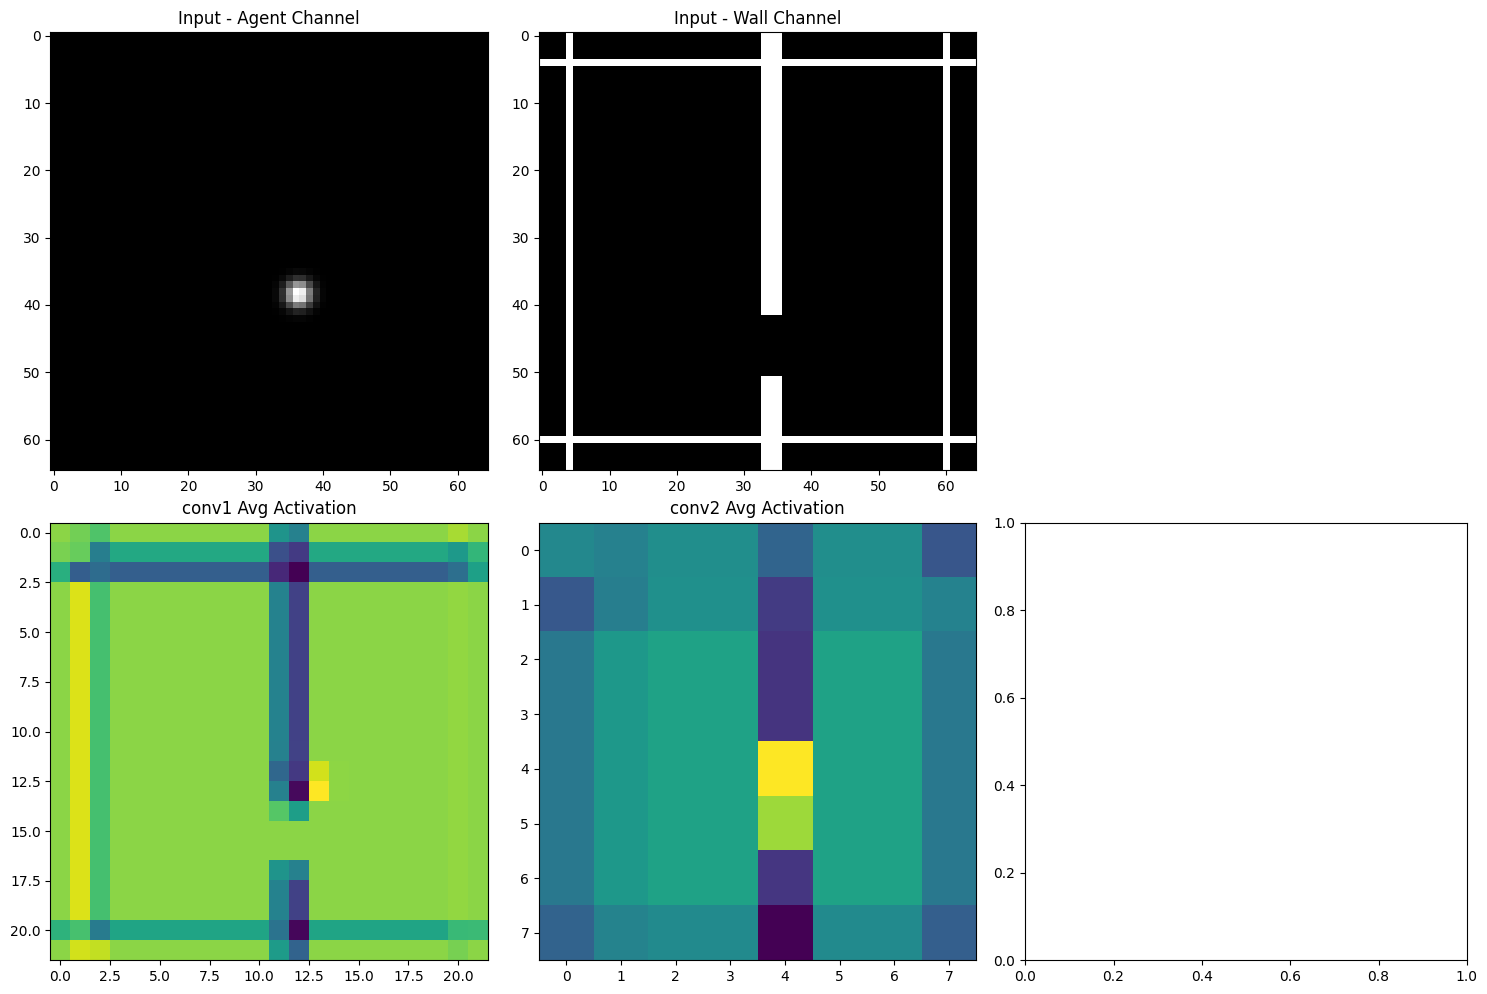

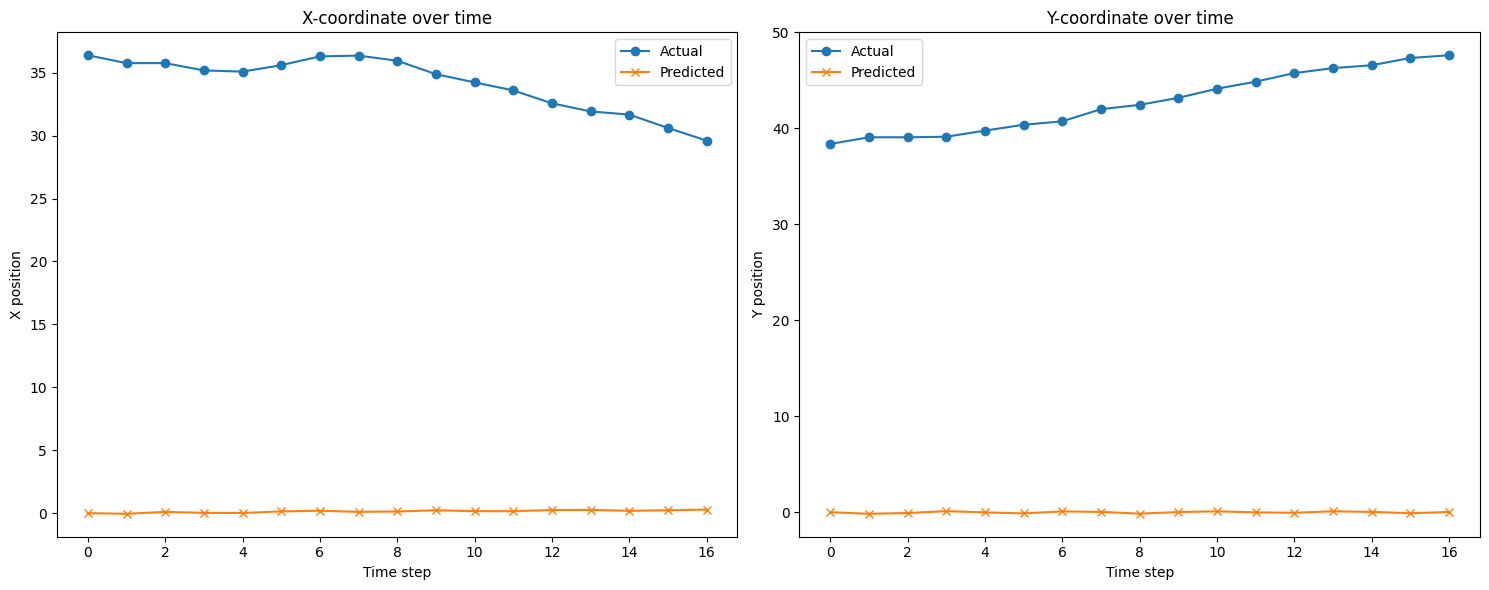

In [8]:

# Main analysis script
if __name__ == "__main__":
    print("Loading model and datasets...")
    model, datasets = load_model_and_data()
    
    print("\nVisualizing convolutional filters...")
    fig1 = visualize_conv_filters(model, layer_idx=0)
    plt.savefig('conv_filters_layer1.png')
    fig2 = visualize_conv_filters(model, layer_idx=1)
    plt.savefig('conv_filters_layer2.png')
    
    print("\nAnalyzing feature maps...")
    sample_batch = next(iter(datasets['normal']))
    activations, init_state = compute_feature_maps(model, sample_batch)
    fig3 = visualize_feature_maps(activations, init_state)
    plt.savefig('feature_maps.png')
    
    print("\nAnalyzing predictions for each dataset...")
    for dataset_name, dataset in datasets.items():
        print(f"\nProcessing {dataset_name} dataset...")
        predictions, targets = analyze_predictions(model, dataset)
        
        # Plot trajectory comparison
        fig4 = plot_trajectory_comparison(predictions, targets)
        plt.savefig(f'trajectory_comparison_{dataset_name}.png')
        
        # Plot error analysis
        mse_over_time = compute_prediction_errors(predictions, targets)
        fig5 = plot_error_analysis(mse_over_time, dataset_name)
        plt.savefig(f'error_analysis_{dataset_name}.png')
        
    print("\nAnalysis complete! All visualizations have been saved.")

Loading model and datasets...
Done!
Visualizing convolutional filters...


/tmp/ipykernel_3429410/4118140400.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('checkpoints/baseline_combined_lr_reduced/checkpoint_epoch_87.

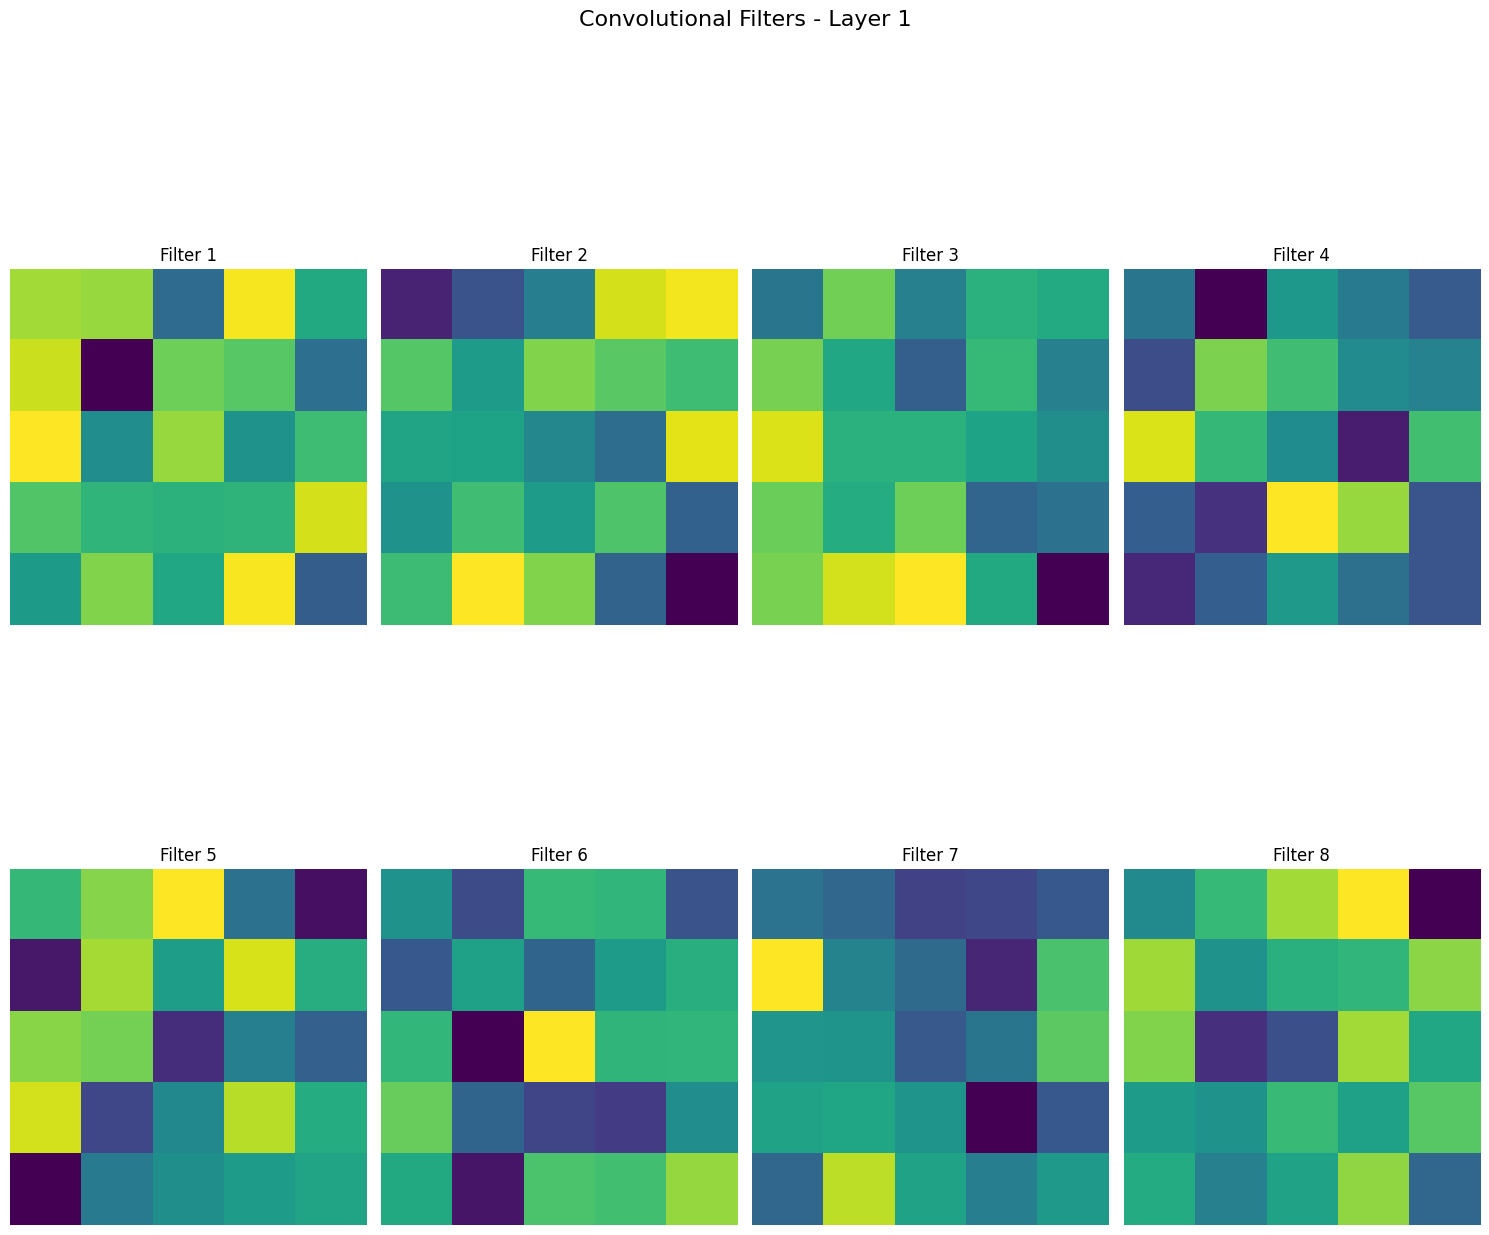

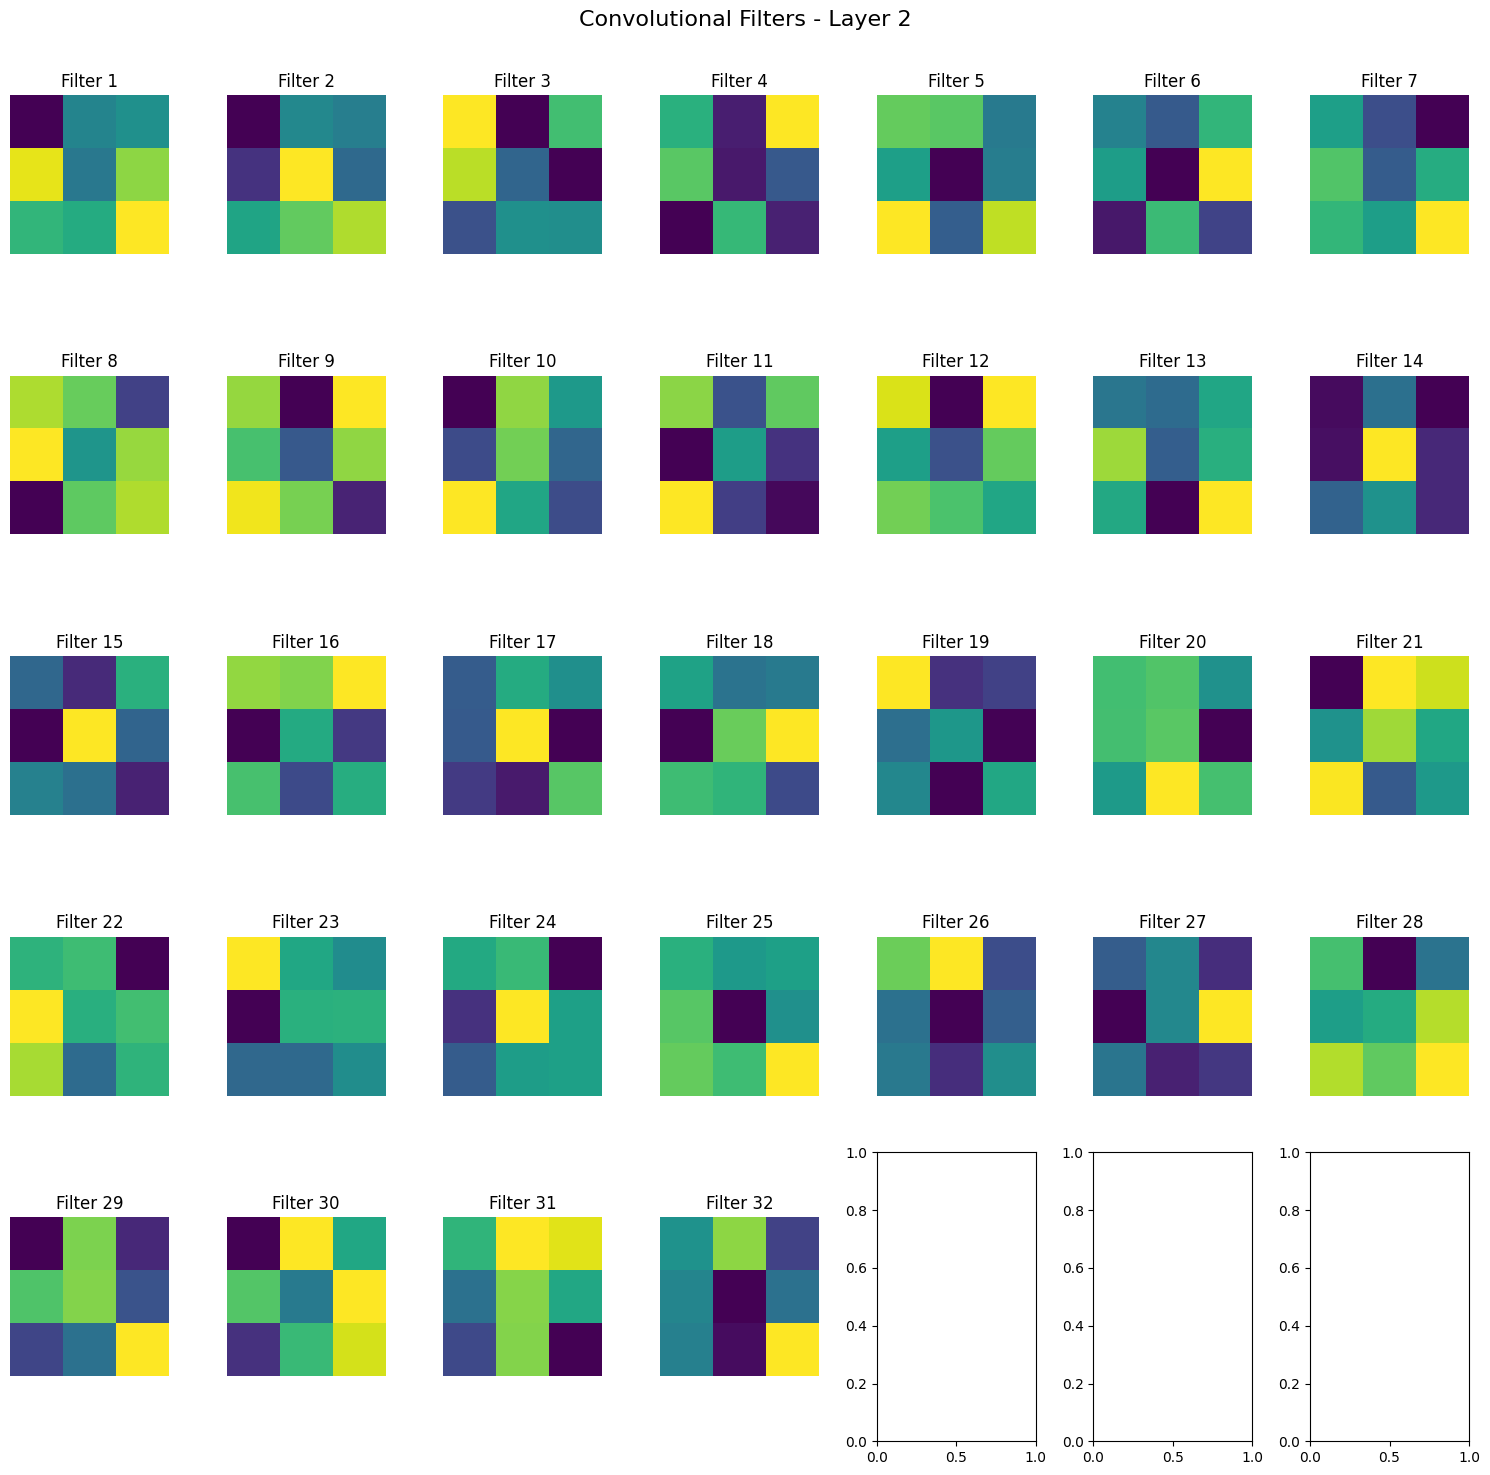

Training prober...



be prediction step:   0%|                                               | 0/156 [00:00<?, ?it/s]

normalized pred locations loss 0.9835867285728455







































































































be prediction step:  65%|███████████████████████▉             | 101/156 [01:01<00:26,  2.09it/s]

normalized pred locations loss 0.036321088671684265

























































Probe prediction step: 100%|█████████████████████████████████████| 156/156 [01:22<00:00,  1.88it/s]









be prediction step:  36%|█████████████▋                        | 56/156 [00:00<00:01, 68.32it/s]

normalized pred locations loss 0.02917550504207611
















Probe prediction epochs:  10%|███▊                                  | 2/20 [01:25<10:38, 35.45s/it]

normalized pred locations loss 0.022223785519599915

















be prediction step:  63%|████████████████████████              | 99/156 [00:01<00:00, 69.27it/s]

normalized pred locations loss 0.022938450798392296










Probe prediction step: 100%|█████████████████████████████████████| 156/156 [00:02<00:00, 69.31it/s]







be prediction step:  29%|███████████▏                          | 46/156 [00:00<00:01, 69.42it/s]

normalized pred locations loss 0.017508629709482193
















be prediction step:  93%|██████████████████████████████████▍  | 145/156 [00:02<00:00, 69.85it/s]

normalized pred locations loss 0.01684202440083027



Probe prediction step: 100%|█████████████████████████████████████| 156/156 [00:02<00:00, 69.48it/s]













be prediction step:  54%|████████████████████▋                 | 85/156 [00:01<00:01, 68.84it/s]

normalized pred locations loss 0.014620336703956127











Probe prediction step: 100%|█████████████████████████████████████| 156/156 [00:02<00:00, 69.65it/s]





be prediction step:  18%|██████▊                               | 28/156 [00:00<00:01, 69.06it/s]

normalized pred locations loss 0.014338579028844833

















be prediction step:  85%|███████████████████████████████▌     | 133/156 [00:01<00:00, 69.01it/s]

normalized pred locations loss 0.00990231242030859





Probe prediction step: 100%|█████████████████████████████████████| 156/156 [00:02<00:00, 69.03it/s]











be prediction step:  46%|█████████████████▌                    | 72/156 [00:01<00:01, 69.54it/s]

normalized pred locations loss 0.010367920622229576














Probe prediction step: 100%|█████████████████████████████████████| 156/156 [00:02<00:00, 68.74it/s]




be prediction step:  13%|█████                                 | 21/156 [00:00<00:01, 67.75it/s]

normalized pred locations loss 0.01029039267450571
















be prediction step:  76%|████████████████████████████▏        | 119/156 [00:01<00:00, 67.41it/s]

normalized pred locations loss 0.009595654904842377







Probe prediction step: 100%|█████████████████████████████████████| 156/156 [00:02<00:00, 67.55it/s]










be prediction step:  40%|███████████████▎                      | 63/156 [00:00<00:01, 68.05it/s]

normalized pred locations loss 0.0075273942202329636















Probe prediction epochs:  45%|█████████████████                     | 9/20 [01:40<00:41,  3.73s/it]

normalized pred locations loss 0.011194982565939426


















be prediction step:  67%|████████████████████████▉            | 105/156 [00:01<00:00, 67.52it/s]

normalized pred locations loss 0.007721748668700457









Probe prediction step: 100%|█████████████████████████████████████| 156/156 [00:02<00:00, 67.72it/s]








be prediction step:  31%|███████████▉                          | 49/156 [00:00<00:01, 67.86it/s]

normalized pred locations loss 0.00884269829839468

















be prediction step:  99%|████████████████████████████████████▌| 154/156 [00:02<00:00, 67.68it/s]

normalized pred locations loss 0.014342933893203735


Probe prediction step: 100%|█████████████████████████████████████| 156/156 [00:02<00:00, 67.68it/s]















be prediction step:  63%|███████████████████████▊              | 98/156 [00:01<00:00, 67.85it/s]

normalized pred locations loss 0.009787379764020443










Probe prediction step: 100%|█████████████████████████████████████| 156/156 [00:02<00:00, 68.03it/s]







be prediction step:  27%|██████████▏                           | 42/156 [00:00<00:01, 69.66it/s]

normalized pred locations loss 0.006320226937532425
















be prediction step:  90%|█████████████████████████████████▏   | 140/156 [00:02<00:00, 69.62it/s]

normalized pred locations loss 0.007246403489261866




Probe prediction step: 100%|█████████████████████████████████████| 156/156 [00:02<00:00, 69.56it/s]












be prediction step:  54%|████████████████████▍                 | 84/156 [00:01<00:01, 71.84it/s]

normalized pred locations loss 0.005900912918150425











Probe prediction step: 100%|█████████████████████████████████████| 156/156 [00:02<00:00, 71.26it/s]




be prediction step:  15%|█████▊                                | 24/156 [00:00<00:01, 72.39it/s]

normalized pred locations loss 0.007010401226580143















be prediction step:  82%|██████████████████████████████▎      | 128/156 [00:01<00:00, 72.31it/s]

normalized pred locations loss 0.00652305455878377





Probe prediction step: 100%|█████████████████████████████████████| 156/156 [00:02<00:00, 71.69it/s]











be prediction step:  46%|█████████████████▎                    | 71/156 [00:01<00:01, 69.58it/s]

normalized pred locations loss 0.007748796604573727













Probe prediction step: 100%|█████████████████████████████████████| 156/156 [00:02<00:00, 69.69it/s]



be prediction step:   9%|███▍                                  | 14/156 [00:00<00:02, 69.51it/s]

normalized pred locations loss 0.013737400993704796
















be prediction step:  72%|██████████████████████████▌          | 112/156 [00:01<00:00, 69.48it/s]

normalized pred locations loss 0.010290433652698994







Probe prediction step: 100%|█████████████████████████████████████| 156/156 [00:02<00:00, 69.58it/s]









be prediction step:  38%|██████████████▌                       | 60/156 [00:00<00:01, 69.62it/s]

normalized pred locations loss 0.007077255751937628















Probe prediction epochs:  90%|█████████████████████████████████▎   | 18/20 [02:01<00:04,  2.29s/it]

normalized pred locations loss 0.009148410521447659

















be prediction step:  65%|███████████████████████▉             | 101/156 [00:01<00:00, 69.59it/s]

normalized pred locations loss 0.0067810183390975









Probe prediction step: 100%|█████████████████████████████████████| 156/156 [00:02<00:00, 69.95it/s]







be prediction step:  30%|███████████▍                          | 47/156 [00:00<00:01, 69.90it/s]

normalized pred locations loss 0.007534862495958805
















be prediction step:  93%|██████████████████████████████████▍  | 145/156 [00:02<00:00, 69.56it/s]

normalized pred locations loss 0.009516328573226929



Probe prediction step: 100%|█████████████████████████████████████| 156/156 [00:02<00:00, 69.67it/s]

robe prediction epochs: 100%|█████████████████████████████████████| 20/20 [02:05<00:00,  6.29s/it]

Prober training complete!

Processing normal dataset...



etting predictions:   6%|██▋                                       | 4/62 [00:00<00:02, 19.71it/s]

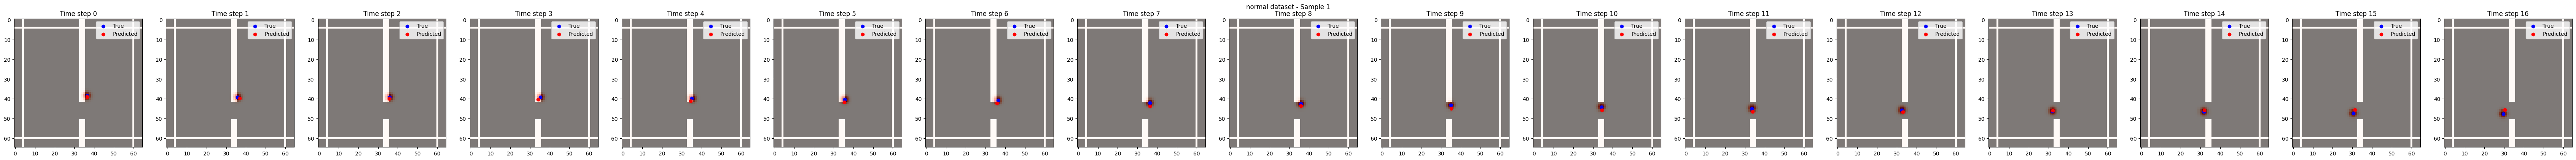

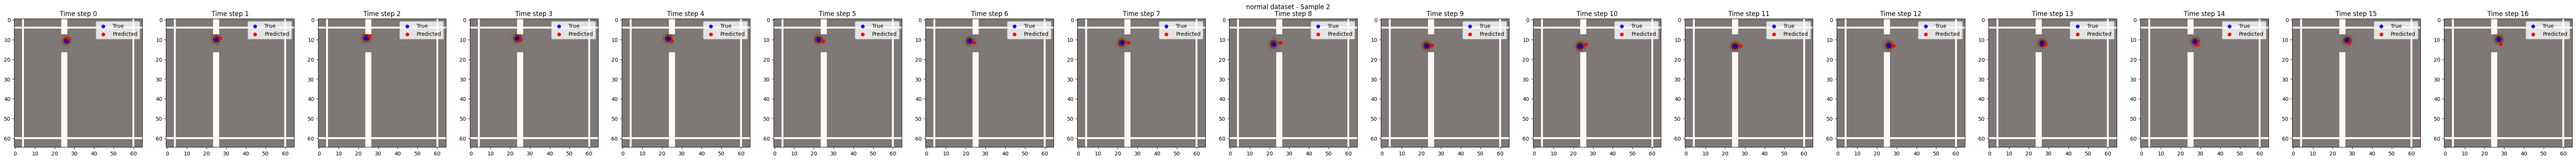

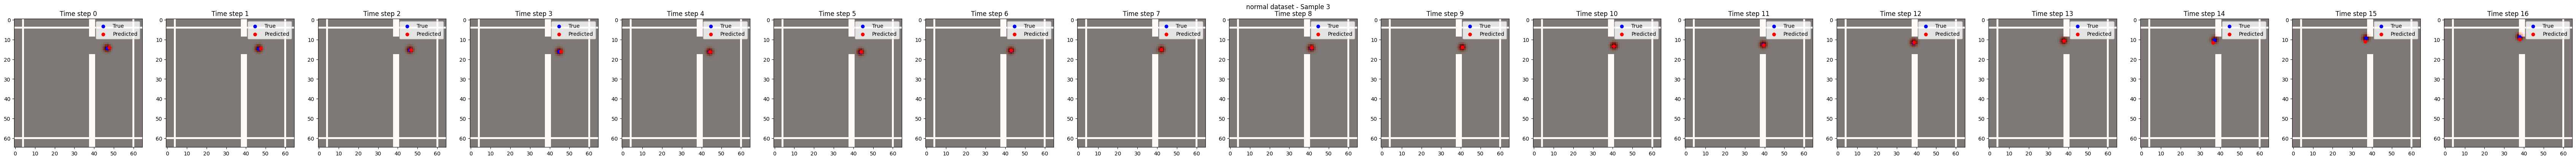


Processing wall dataset...



etting predictions:   6%|██▋                                       | 4/62 [00:01<00:25,  2.23it/s]

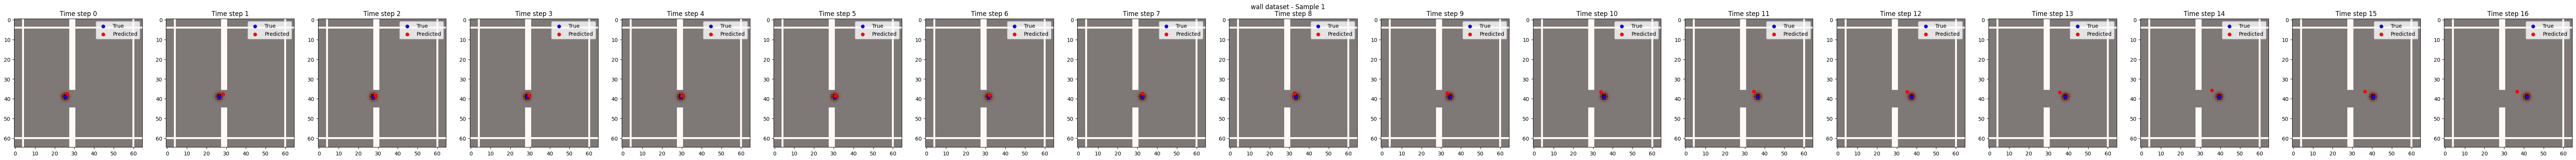

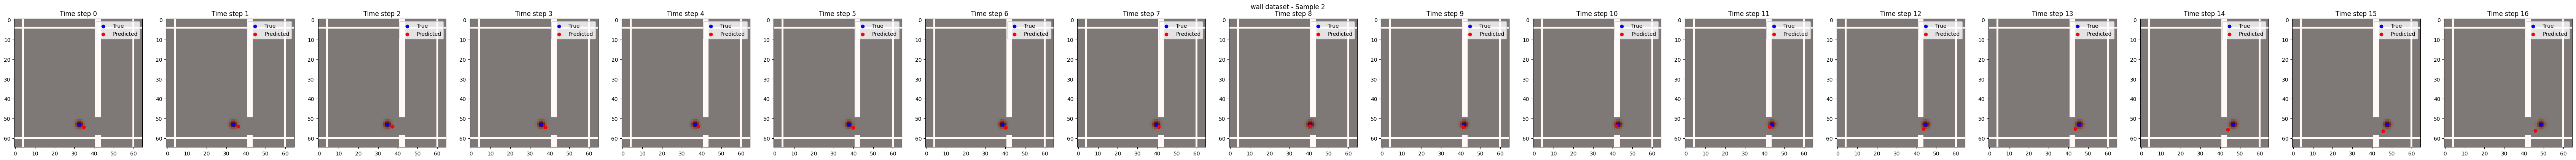

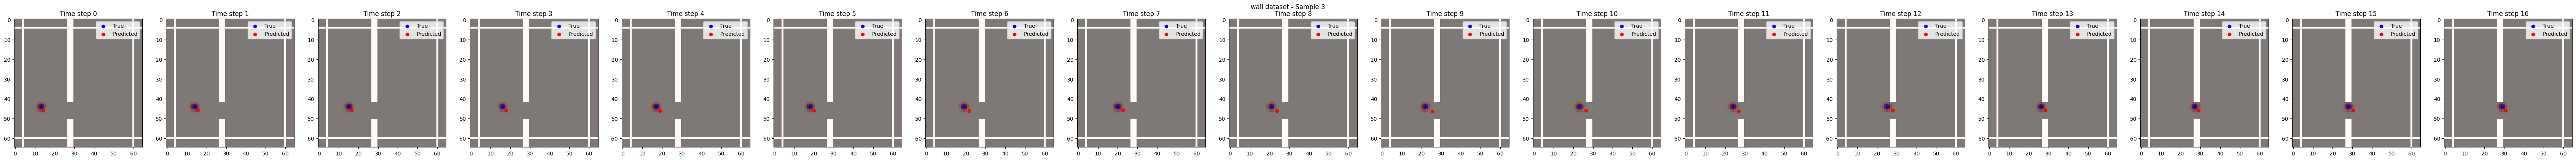


Processing wall_other dataset...



etting predictions:   6%|██▋                                       | 4/62 [00:04<01:03,  1.10s/it]

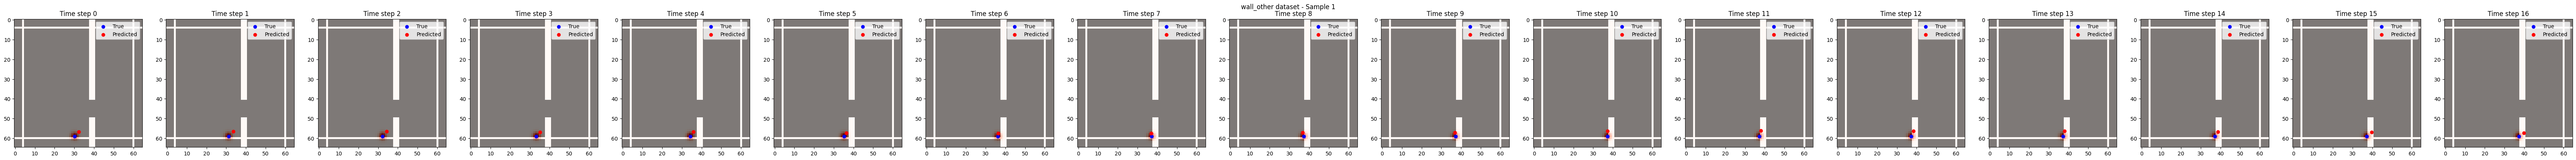

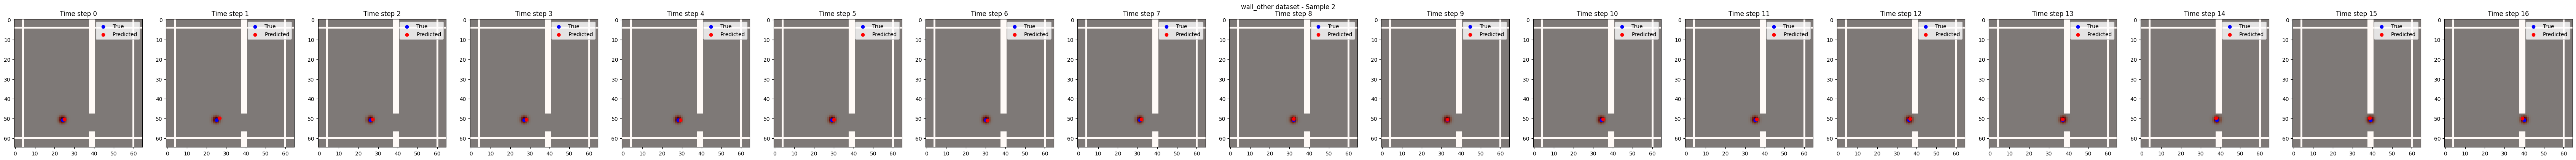

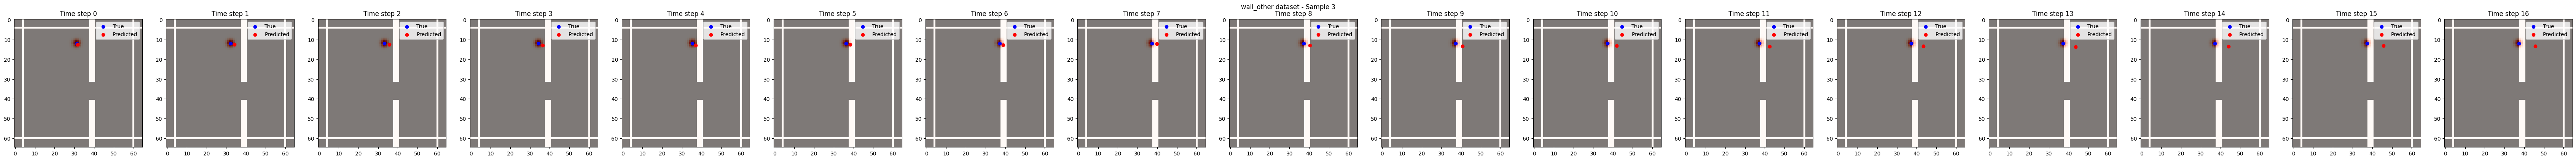


Error Statistics:



etting predictions:   6%|██▋                                       | 4/62 [00:00<00:01, 32.46it/s]


normal dataset:
mean: 1.9100
std: 1.4474
median: 1.6098
max: 14.8912
min: 0.0176



etting predictions:   6%|██▋                                       | 4/62 [00:00<00:01, 29.54it/s]


wall dataset:
mean: 2.8431
std: 2.2131
median: 2.2006
max: 14.5301
min: 0.0389



etting predictions:   6%|██▋                                       | 4/62 [00:00<00:01, 31.33it/s]


wall_other dataset:
mean: 2.8281
std: 2.2269
median: 2.1577
max: 13.8996
min: 0.0149


In [11]:
# Imports and Setup
import torch
import matplotlib.pyplot as plt
import numpy as np
from models import WorldModel
from dataset import create_wall_dataloader
from evaluator import ProbingEvaluator
from normalizer import Normalizer
import seaborn as sns
from tqdm import tqdm

# Set Matplotlib style
# plt.style.use('seaborn')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Cell 1: Load Model and Data
def load_model():
    """Load the trained model"""
    model = WorldModel(loss_type='both')
    checkpoint = torch.load('checkpoints/baseline_combined_lr_reduced/checkpoint_epoch_87.pt')
    model.load_state_dict(checkpoint['model_state_dict'])
    model.cuda()
    model.eval()
    return model

def load_datasets():
    """Load all datasets"""
    datasets = {}
    
    # Training dataset for prober
    datasets['probe_train'] = create_wall_dataloader(
        data_path=f"/drive_reader/as16386/DL24FA/probe_normal/train",
        probing=True,
        device=device,
        train=True,
    )
    
    # Validation datasets
    for dataset_name in ['normal', 'wall', 'wall_other']:
        datasets[dataset_name] = create_wall_dataloader(
            data_path=f"/drive_reader/as16386/DL24FA/probe_{dataset_name}/val",
            probing=True,
            device=device,
            train=False,
        )
    
    return datasets

print("Loading model and datasets...")
model = load_model()
datasets = load_datasets()
print("Done!")

# Cell 2: Visualize CNN Filters
def visualize_conv_filters(model, layer_idx=0):
    """Visualize convolutional filters from the encoder"""
    conv_layer = model.encoder.conv1 if layer_idx == 0 else model.encoder.conv2
    weights = conv_layer.weight.data.cpu()
    weights = (weights - weights.min()) / (weights.max() - weights.min())
    
    n_filters = weights.shape[0]
    n_rows = int(np.sqrt(n_filters))
    n_cols = int(np.ceil(n_filters / n_rows))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15))
    axes = axes.flatten()
    
    for i in range(n_filters):
        filter_img = weights[i].mean(dim=0)
        axes[i].imshow(filter_img, cmap='viridis')
        axes[i].axis('off')
        axes[i].set_title(f'Filter {i+1}')
    
    plt.suptitle(f'Convolutional Filters - Layer {layer_idx+1}', size=16)
    plt.tight_layout()
    plt.show()

print("Visualizing convolutional filters...")
visualize_conv_filters(model, layer_idx=0)
visualize_conv_filters(model, layer_idx=1)

# Cell 3: Train Prober
def train_and_get_prober():
    """Train prober using the evaluator"""
    print("Training prober...")
    evaluator = ProbingEvaluator(
        device=device,
        model=model,
        probe_train_ds=datasets['probe_train'],
        probe_val_ds={k: v for k, v in datasets.items() if k != 'probe_train'},
        quick_debug=False,
    )
    
    prober = evaluator.train_pred_prober()
    print("Prober training complete!")
    return prober, evaluator

prober, evaluator = train_and_get_prober()

# Cell 4: Visualization Functions
def visualize_trajectory(states, true_locations, pred_locations, title="Trajectory Visualization"):
    """Visualize the environment, true positions, and predicted positions"""
    # Take first sample from batch
    state = states[0]  # Shape: [T, 2, H, W]
    true_pos = true_locations[0]  # Shape: [T, 2]
    pred_pos = pred_locations[0]  # Shape: [T, 2]
    
    T = state.shape[0]
    fig, axes = plt.subplots(1, T, figsize=(4*T, 4))
    if T == 1:
        axes = [axes]
    
    for t in range(T):
        # Plot environment (walls and agent)
        axes[t].imshow(state[t, 1].cpu(), cmap='gray')  # Walls
        axes[t].imshow(state[t, 0].cpu(), cmap='Reds', alpha=0.5)  # Agent
        
        # Plot true and predicted positions
        axes[t].scatter(true_pos[t, 0], true_pos[t, 1], c='blue', label='True')
        axes[t].scatter(pred_pos[t, 0], pred_pos[t, 1], c='red', label='Predicted')
        
        axes[t].set_title(f'Time step {t}')
        axes[t].legend()
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Cell 5: Get Predictions and Visualize for Each Dataset
def get_predictions(dataset, prober, evaluator):
    """Get predictions for a dataset using the trained prober"""
    normalizer = Normalizer()
    predictions = []
    true_positions = []
    states_list = []
    
    with torch.no_grad():
        for batch in tqdm(dataset, desc="Getting predictions"):
            # Get initial state and predict
            init_states = batch.states[:, 0:1]
            pred_encs = model(states=init_states, actions=batch.actions)
            pred_encs = pred_encs.transpose(0, 1)  # [B, T, D] -> [T, B, D]
            
            # Get predictions from prober
            pred_locs = torch.stack([prober(x) for x in pred_encs], dim=1)
            
            # Unnormalize predictions and true locations
            pred_locs = normalizer.unnormalize_location(pred_locs)
            true_locs = batch.locations
            
            predictions.append(pred_locs.cpu())
            true_positions.append(true_locs.cpu())
            states_list.append(batch.states.cpu())
            
            # Only process a few batches for visualization
            if len(predictions) >= 5:
                break
    
    return torch.cat(states_list), torch.cat(true_positions), torch.cat(predictions)

# Cell 6: Visualize Each Dataset
for dataset_name, dataset in datasets.items():
    if dataset_name == 'probe_train':
        continue
        
    print(f"\nProcessing {dataset_name} dataset...")
    states, true_positions, pred_positions = get_predictions(dataset, prober, evaluator)
    
    # Visualize a few samples
    for i in range(min(3, len(states))):
        visualize_trajectory(
            states[i:i+1], 
            true_positions[i:i+1], 
            pred_positions[i:i+1],
            title=f"{dataset_name} dataset - Sample {i+1}"
        )

# Cell 7: Compute and Display Error Statistics
def compute_error_stats(true_positions, pred_positions):
    """Compute error statistics for predictions"""
    errors = (pred_positions - true_positions).pow(2).sum(dim=-1).sqrt()
    return {
        'mean': errors.mean().item(),
        'std': errors.std().item(),
        'median': errors.median().item(),
        'max': errors.max().item(),
        'min': errors.min().item()
    }

print("\nError Statistics:")
for dataset_name, dataset in datasets.items():
    if dataset_name == 'probe_train':
        continue
        
    _, true_positions, pred_positions = get_predictions(dataset, prober, evaluator)
    stats = compute_error_stats(true_positions, pred_positions)
    
    print(f"\n{dataset_name} dataset:")
    for stat_name, value in stats.items():
        print(f"{stat_name}: {value:.4f}")

Visualizing input images and activations for a few samples...

Sample 1:


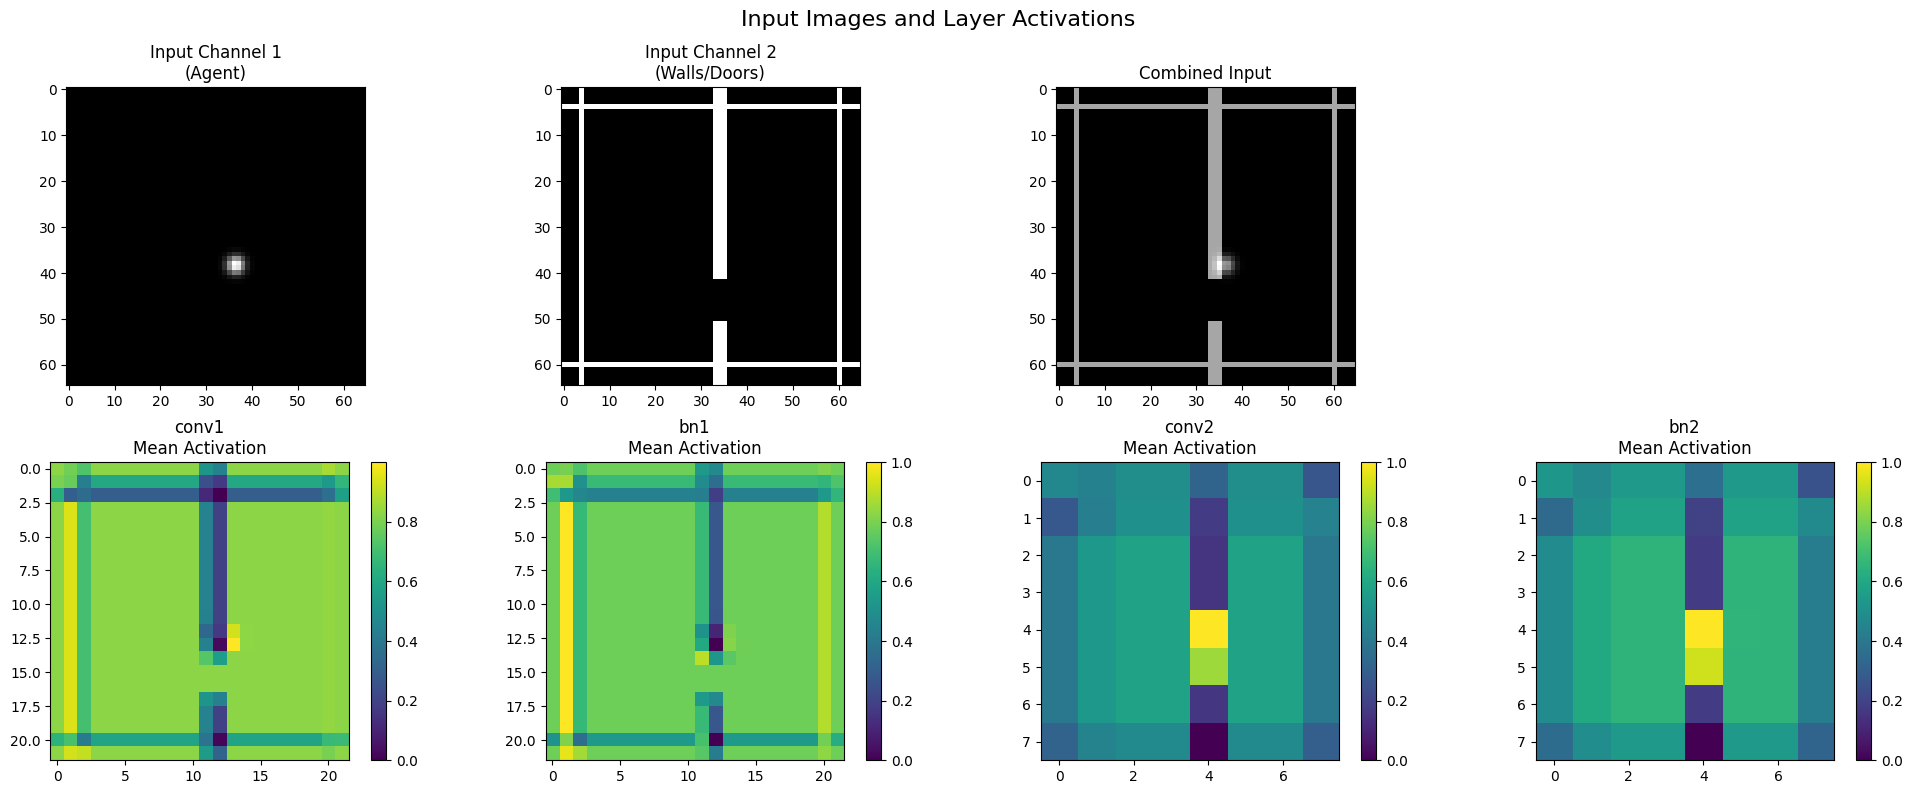

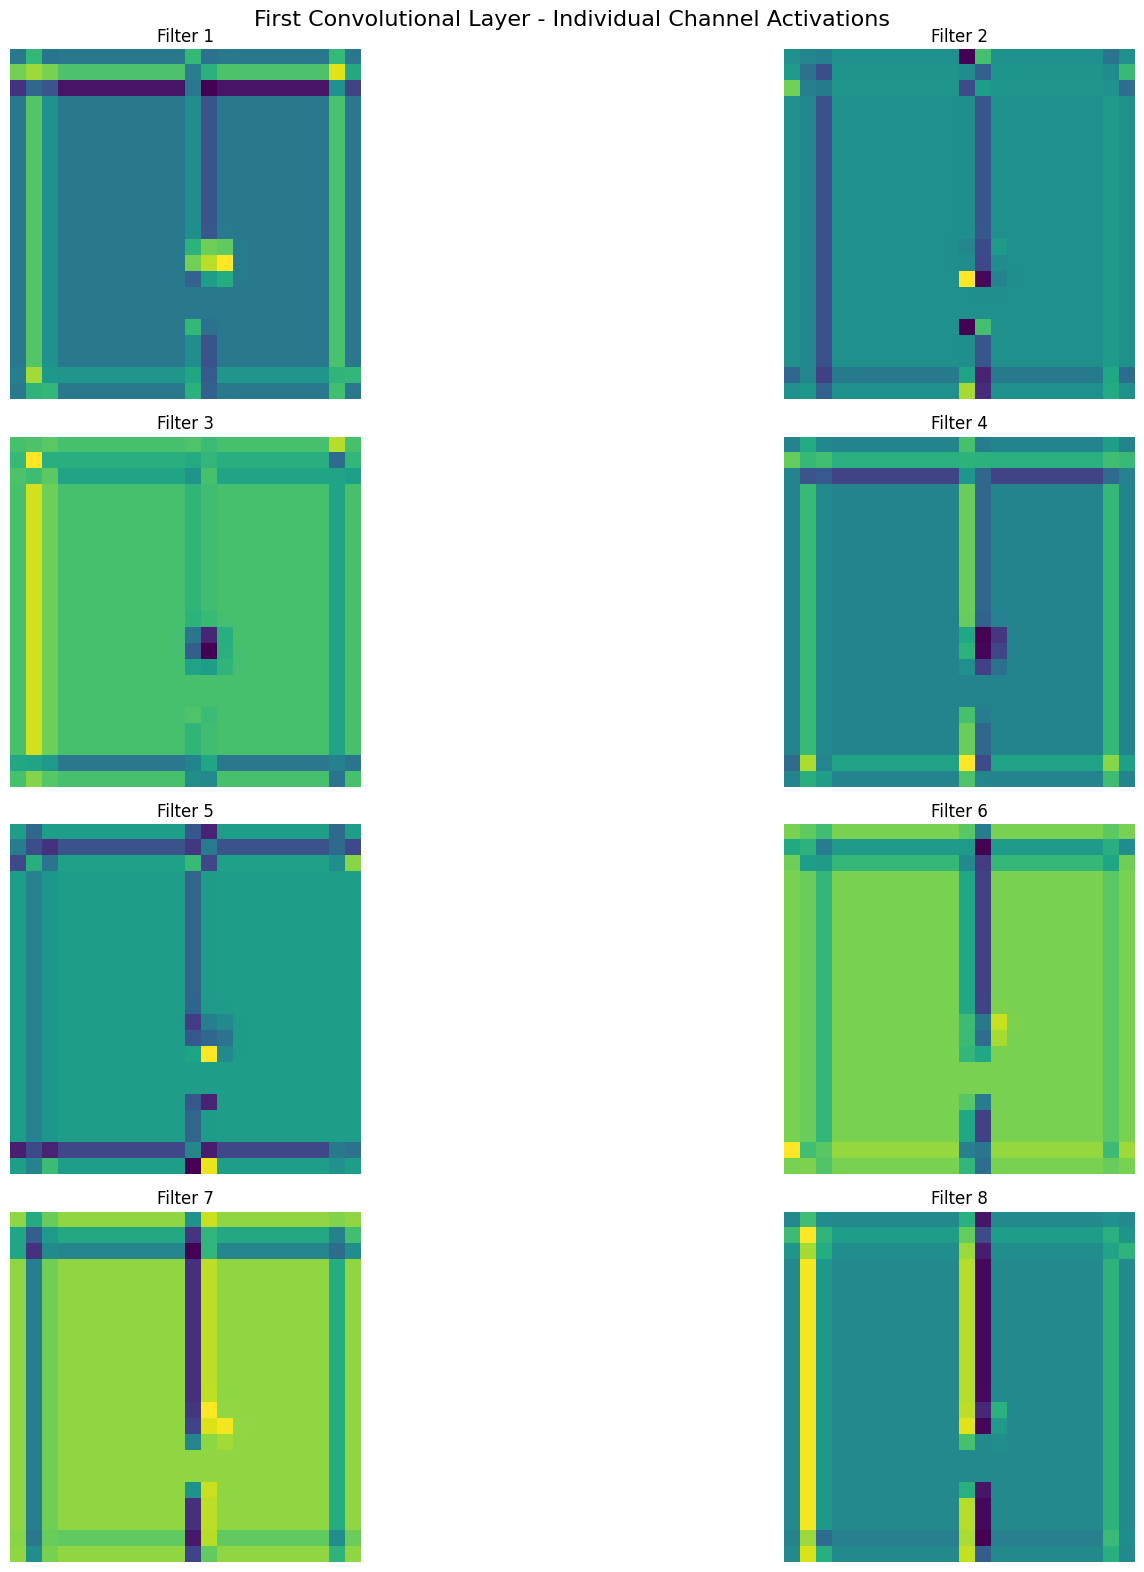


Sample 2:


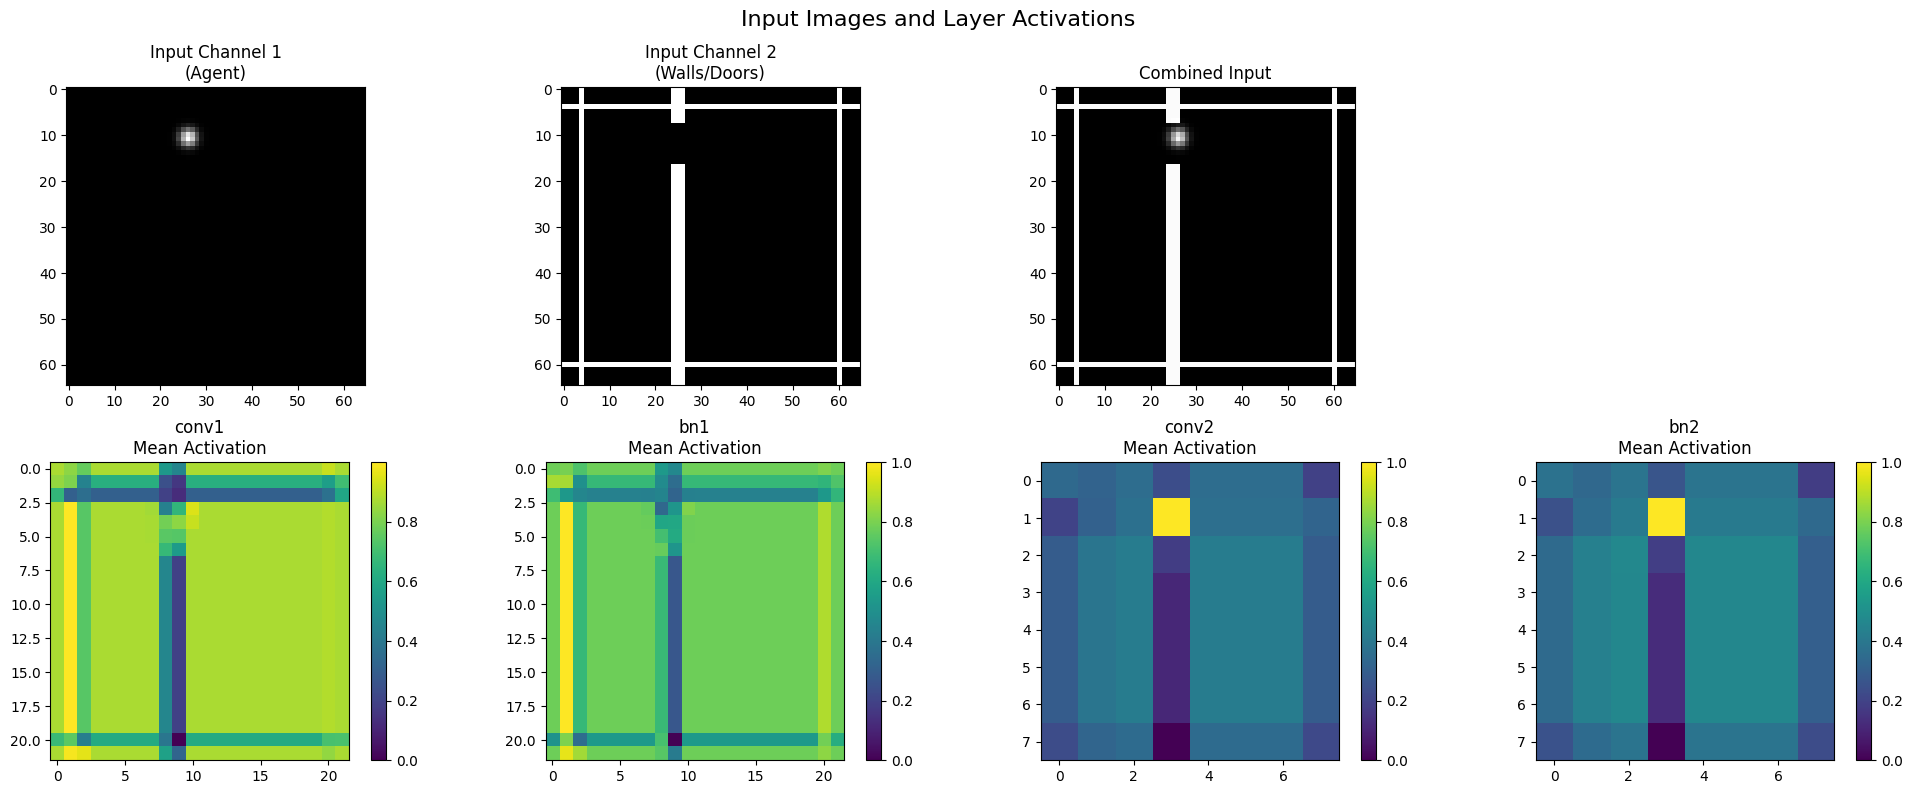

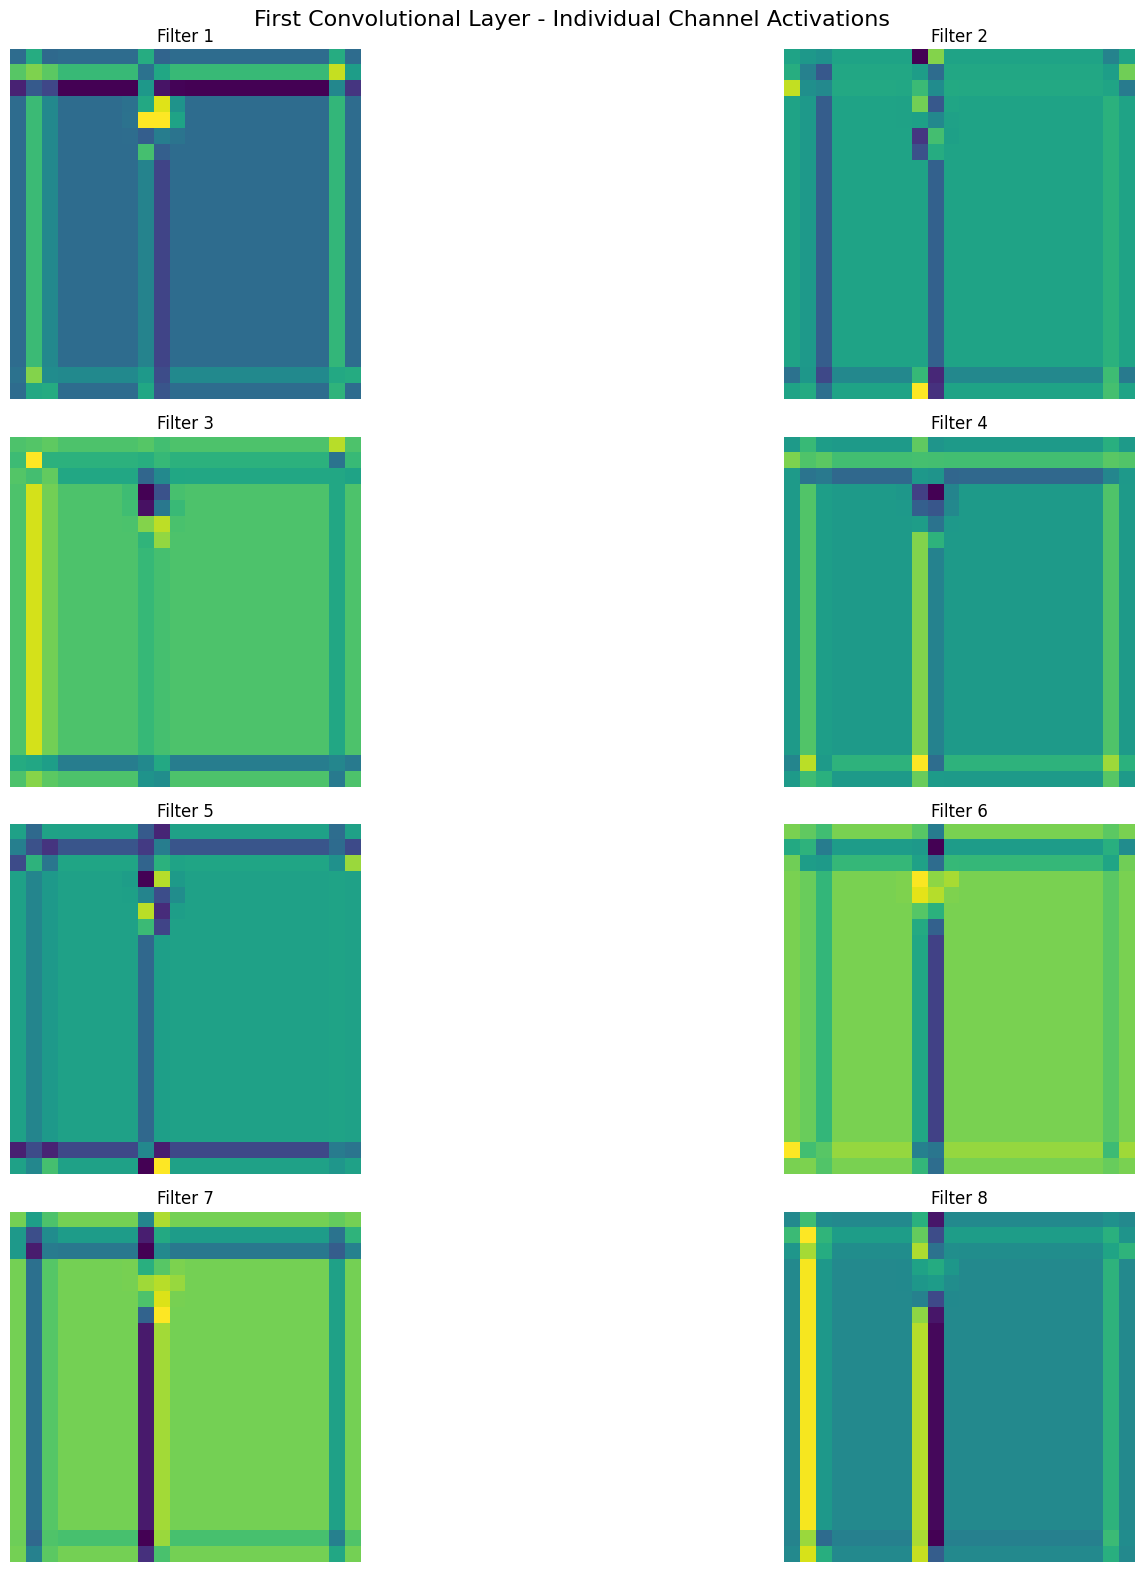


Sample 3:


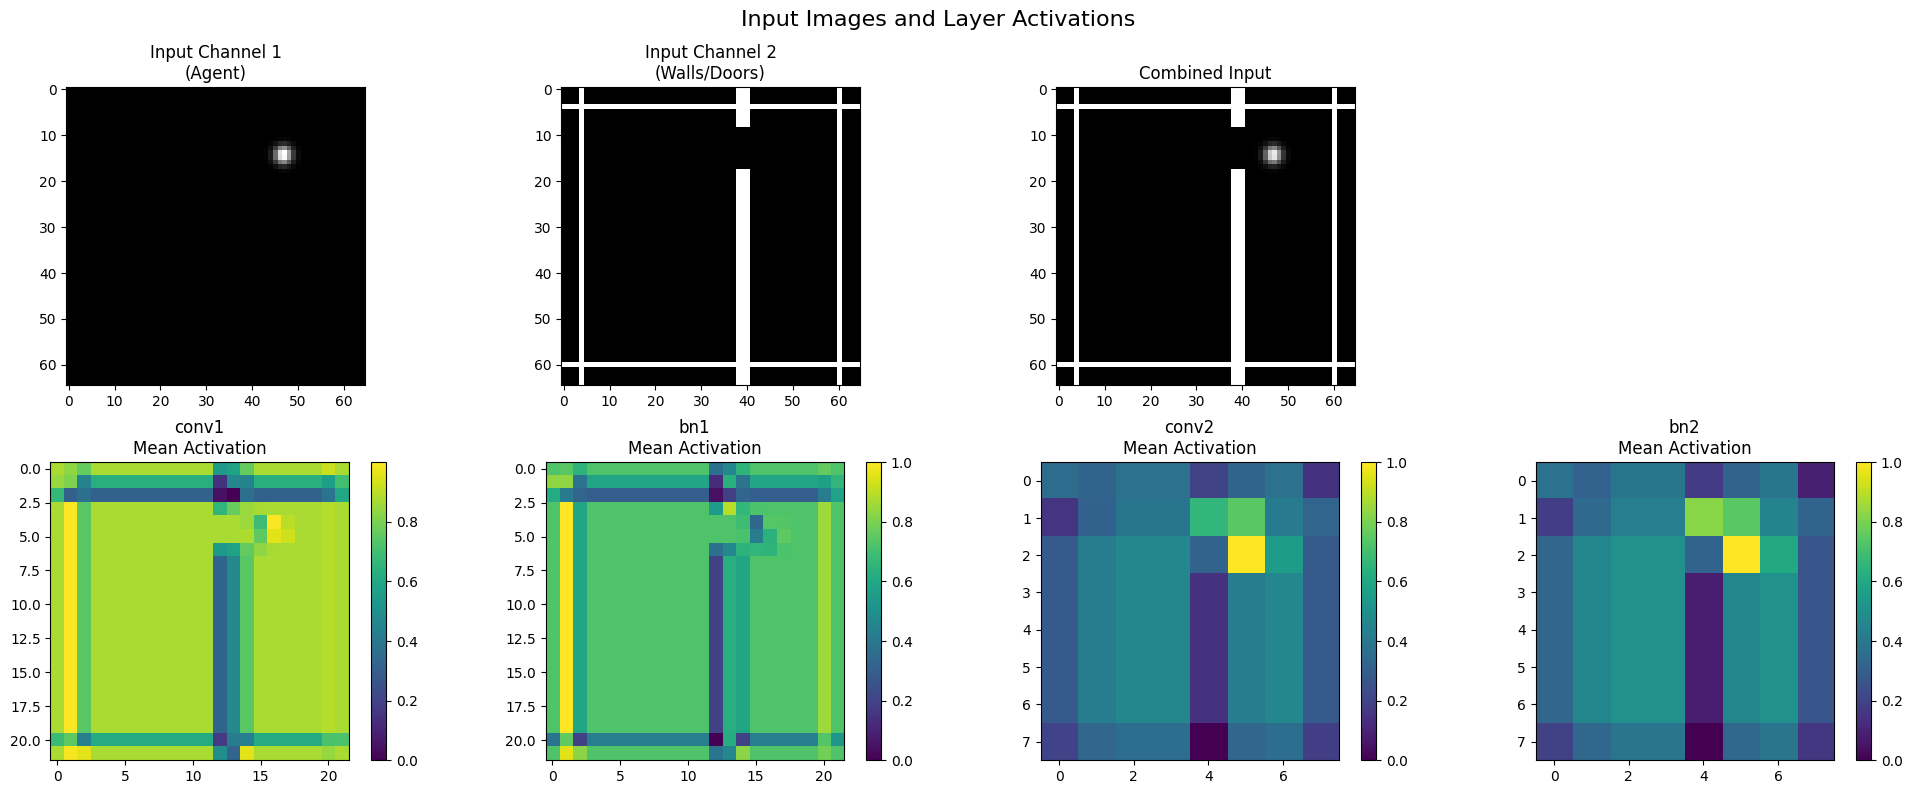

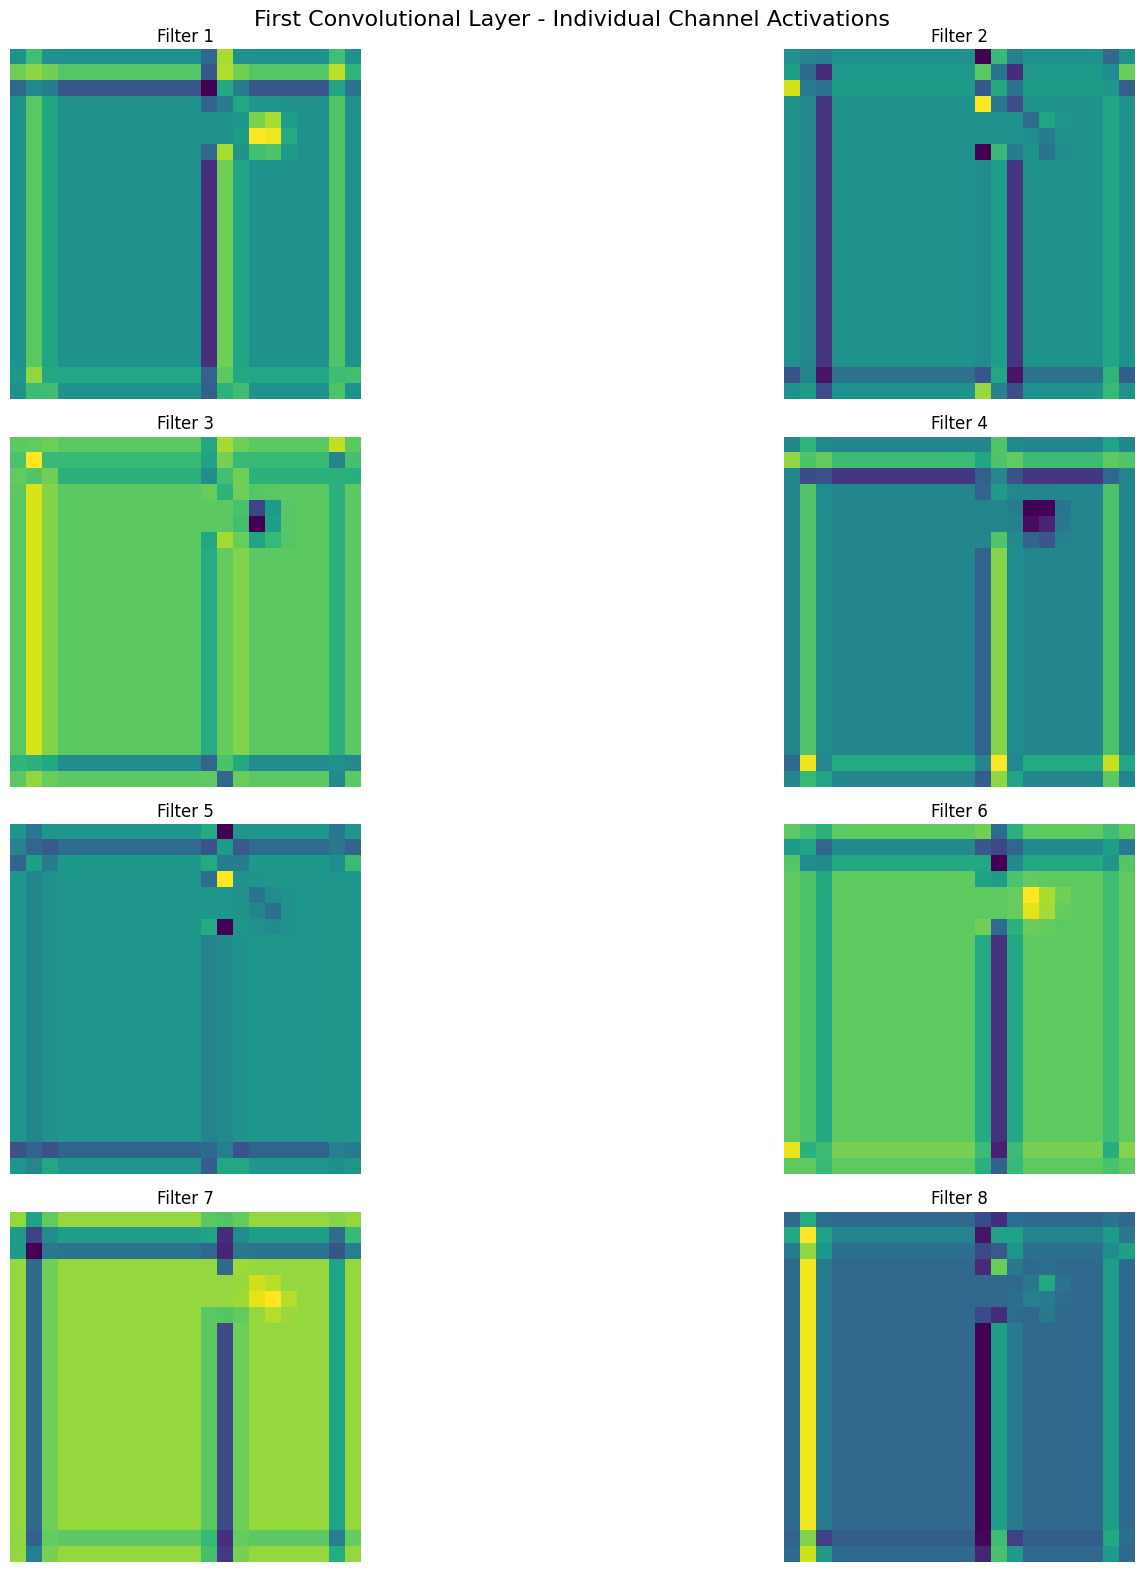

In [12]:
def get_layer_activations(model, input_batch):
    """Get activations from each layer for an input batch"""
    activations = {}
    
    def hook_fn(name):
        def hook(module, input, output):
            activations[name] = output.detach()
        return hook
    
    # Register hooks for each layer we want to visualize
    hooks = []
    hooks.append(model.encoder.conv1.register_forward_hook(hook_fn('conv1')))
    hooks.append(model.encoder.bn1.register_forward_hook(hook_fn('bn1')))
    hooks.append(model.encoder.conv2.register_forward_hook(hook_fn('conv2')))
    hooks.append(model.encoder.bn2.register_forward_hook(hook_fn('bn2')))
    
    # Forward pass
    with torch.no_grad():
        _ = model(states=input_batch.states[:, 0:1], actions=input_batch.actions)
    
    # Remove hooks
    for hook in hooks:
        hook.remove()
    
    return activations

def visualize_input_and_activations(model, batch, sample_idx=0):
    """Visualize input images and their activations through the network"""
    # Get input image and activations
    input_state = batch.states[sample_idx, 0]  # First timestep of the sample
    
    # Create a batch of single sample
    single_batch = type(batch)(
        states=batch.states[sample_idx:sample_idx+1],
        actions=batch.actions[sample_idx:sample_idx+1],
        locations=batch.locations[sample_idx:sample_idx+1]
    )
    activations = get_layer_activations(model, single_batch)
    
    # Plot setup
    n_cols = 4  # Input channels + activation summaries
    fig, axes = plt.subplots(2, n_cols, figsize=(20, 8))
    
    # Plot input channels
    axes[0, 0].imshow(input_state[0].cpu(), cmap='gray')
    axes[0, 0].set_title('Input Channel 1\n(Agent)')
    axes[0, 1].imshow(input_state[1].cpu(), cmap='gray')
    axes[0, 1].set_title('Input Channel 2\n(Walls/Doors)')
    
    # Plot combined input
    combined = input_state[0].cpu() + input_state[1].cpu()
    axes[0, 2].imshow(combined, cmap='gray')
    axes[0, 2].set_title('Combined Input')
    axes[0, 3].axis('off')
    
    # Plot activation maps
    activation_names = ['conv1', 'bn1', 'conv2', 'bn2']
    for idx, name in enumerate(activation_names):
        if name in activations:
            # Get activation and move to CPU
            act = activations[name][0].cpu()  # First sample
            
            # Calculate mean activation across channels
            mean_activation = act.mean(dim=0)
            
            # Normalize for visualization
            mean_activation = (mean_activation - mean_activation.min()) / \
                            (mean_activation.max() - mean_activation.min() + 1e-8)
            
            # Plot
            im = axes[1, idx].imshow(mean_activation, cmap='viridis')
            axes[1, idx].set_title(f'{name}\nMean Activation')
            plt.colorbar(im, ax=axes[1, idx])
    
    plt.suptitle('Input Images and Layer Activations', size=16)
    plt.tight_layout()
    plt.show()
    
    # Optional: Visualize individual channel activations for first conv layer
    n_filters = activations['conv1'].shape[1]
    n_rows = 4
    n_cols = n_filters // n_rows
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 16))
    for i in range(n_filters):
        row = i // n_cols
        col = i % n_cols
        
        activation = activations['conv1'][0, i].cpu()
        activation = (activation - activation.min()) / (activation.max() - activation.min() + 1e-8)
        
        axes[row, col].imshow(activation, cmap='viridis')
        axes[row, col].axis('off')
        axes[row, col].set_title(f'Filter {i+1}')
    
    plt.suptitle('First Convolutional Layer - Individual Channel Activations', size=16)
    plt.tight_layout()
    plt.show()

# Example usage:
print("Visualizing input images and activations for a few samples...")
dataset = datasets['normal']  # Use normal validation dataset
for i in range(3):  # Show 3 different samples
    batch = next(iter(dataset))
    print(f"\nSample {i+1}:")
    visualize_input_and_activations(model, batch, sample_idx=i)

Starting visualization generation...
Saving convolutional filters...


<Figure size 640x480 with 0 Axes>

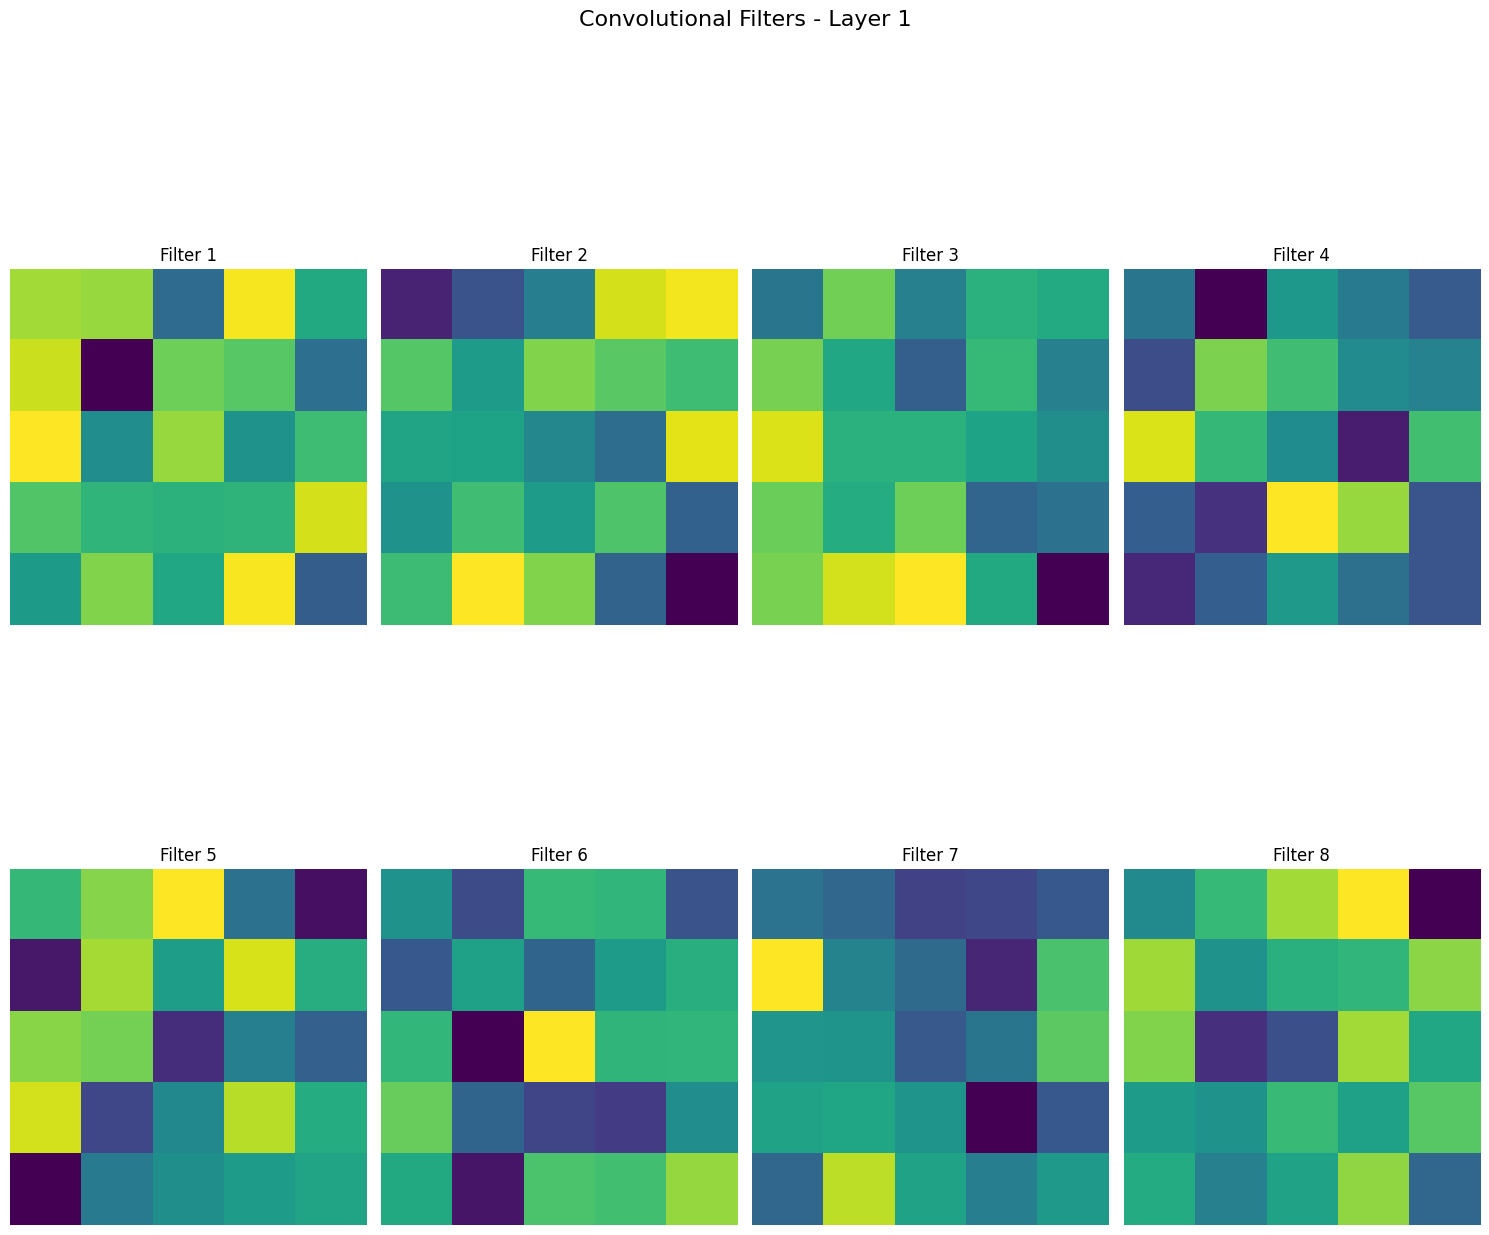

<Figure size 640x480 with 0 Axes>

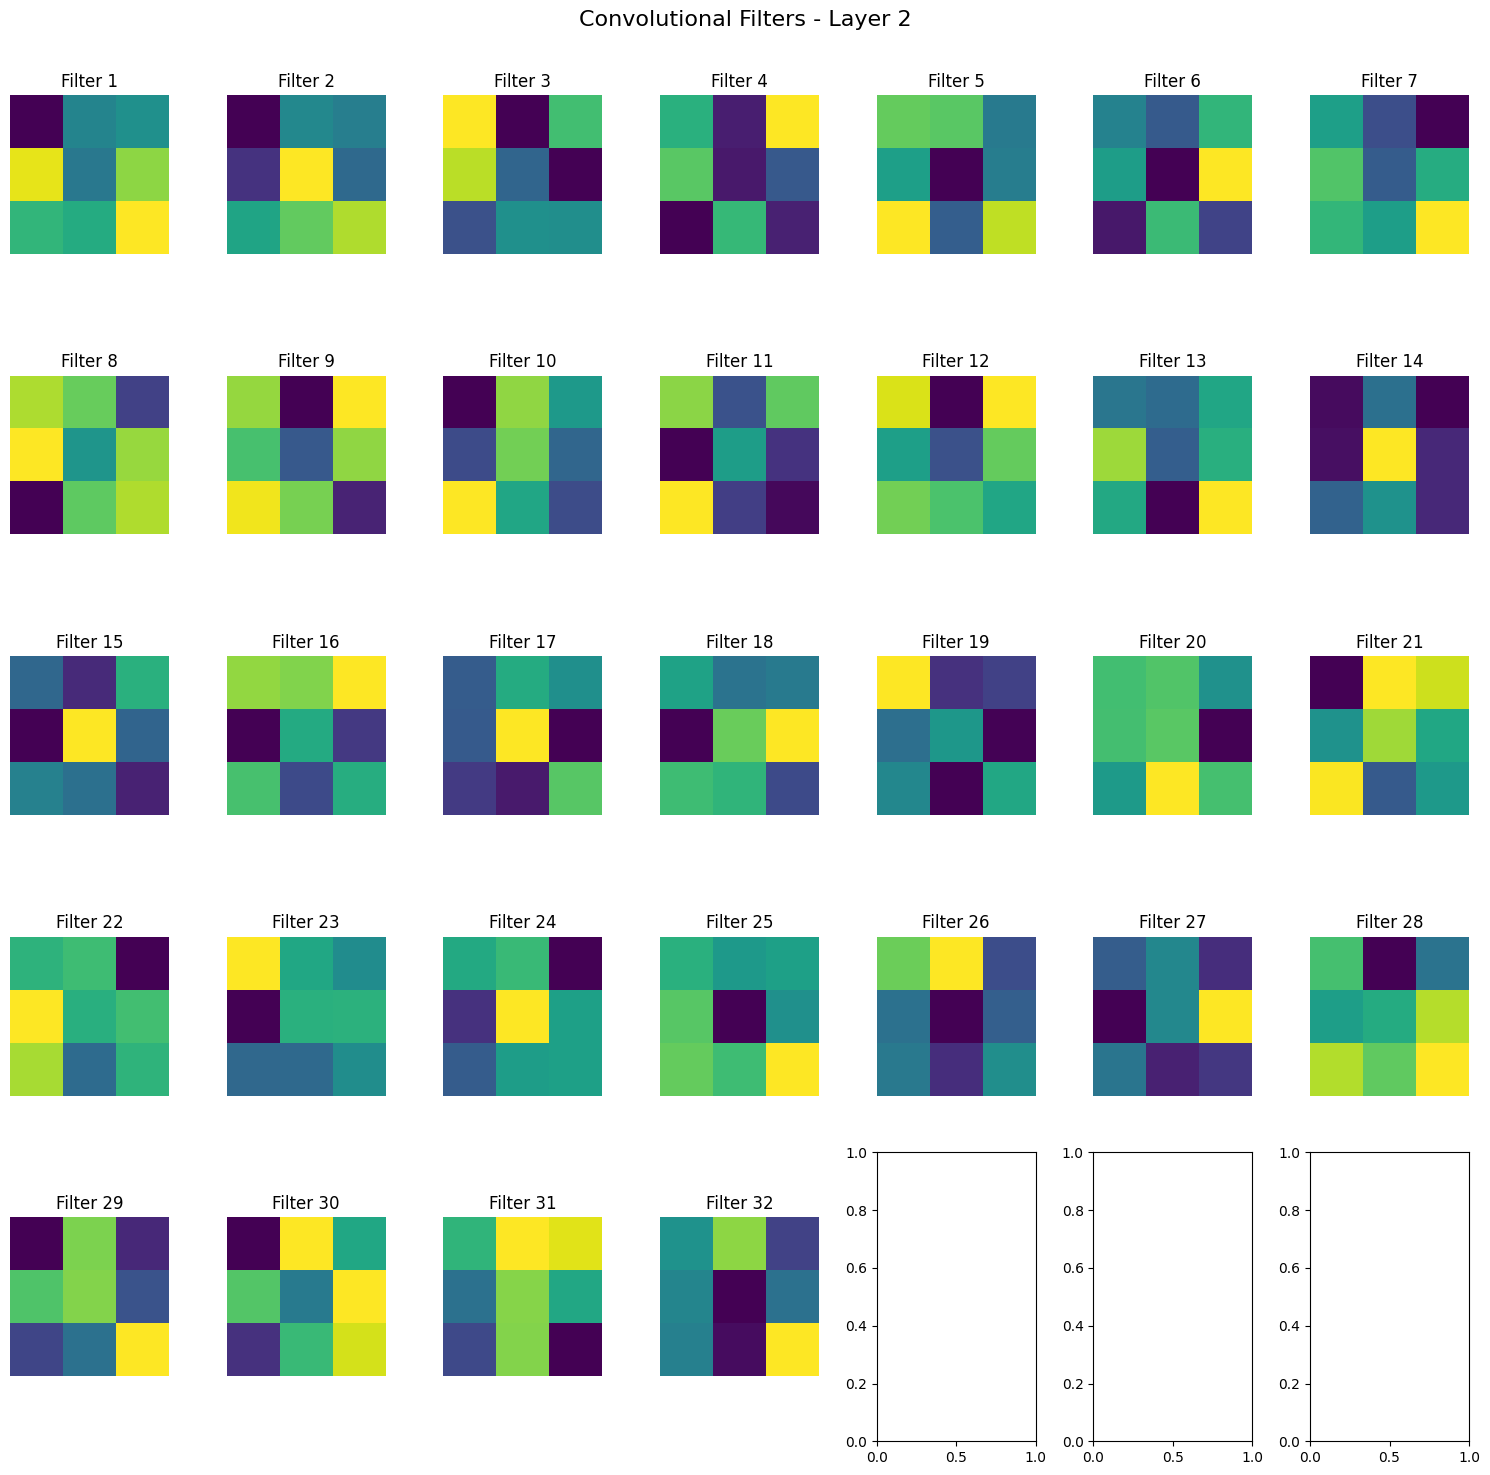


Saving activation maps...


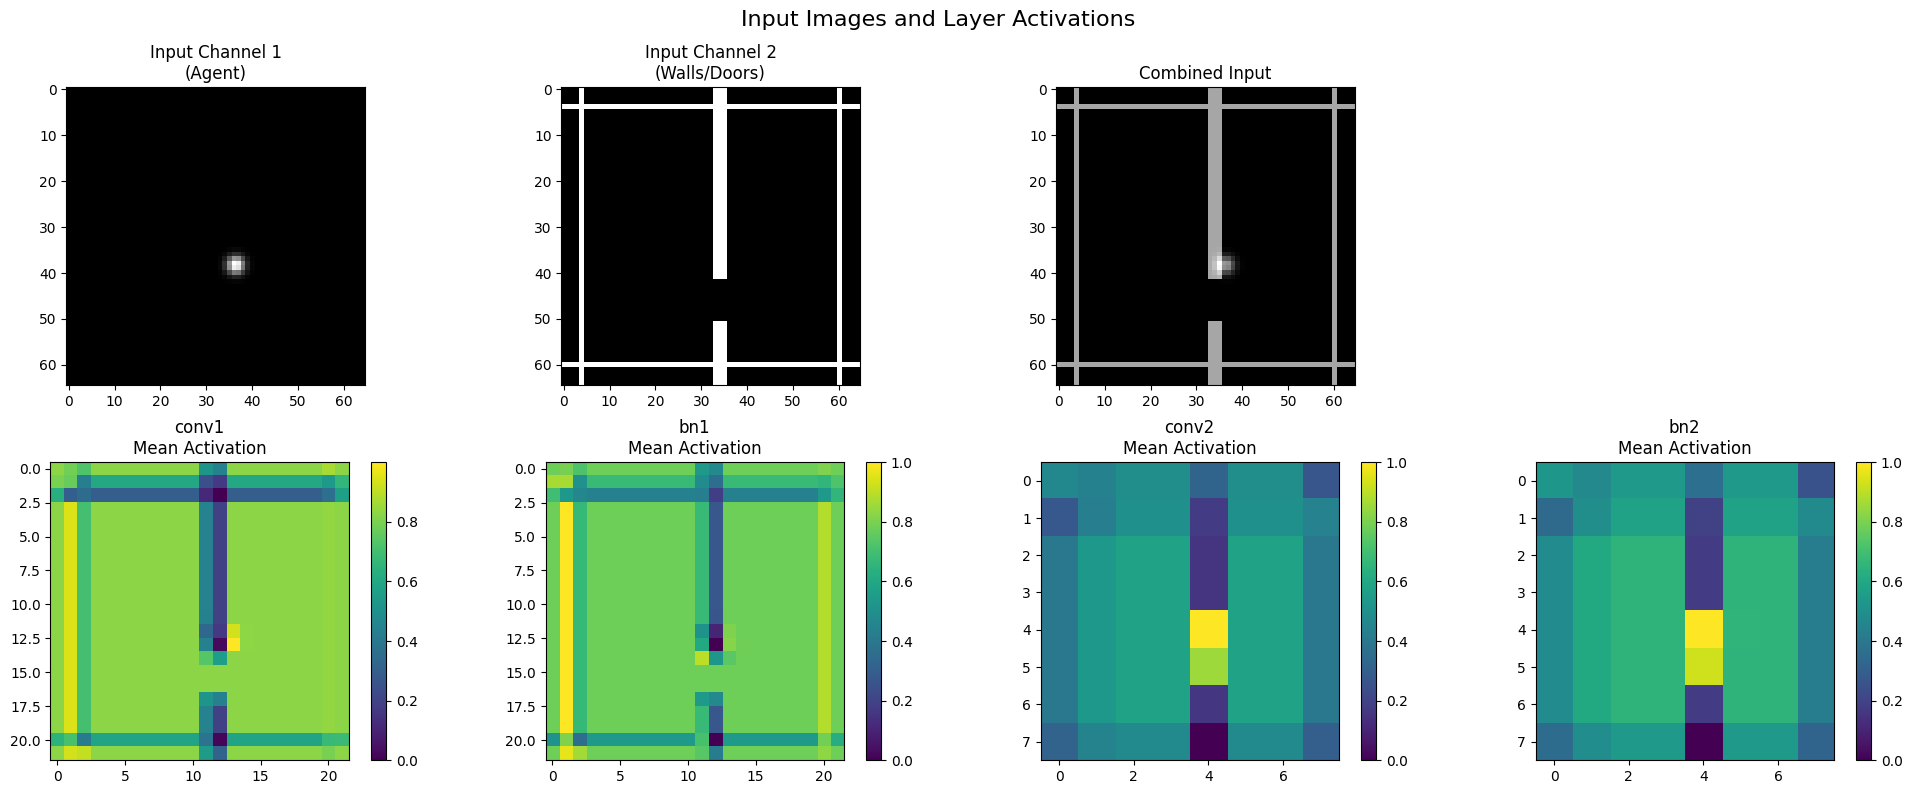

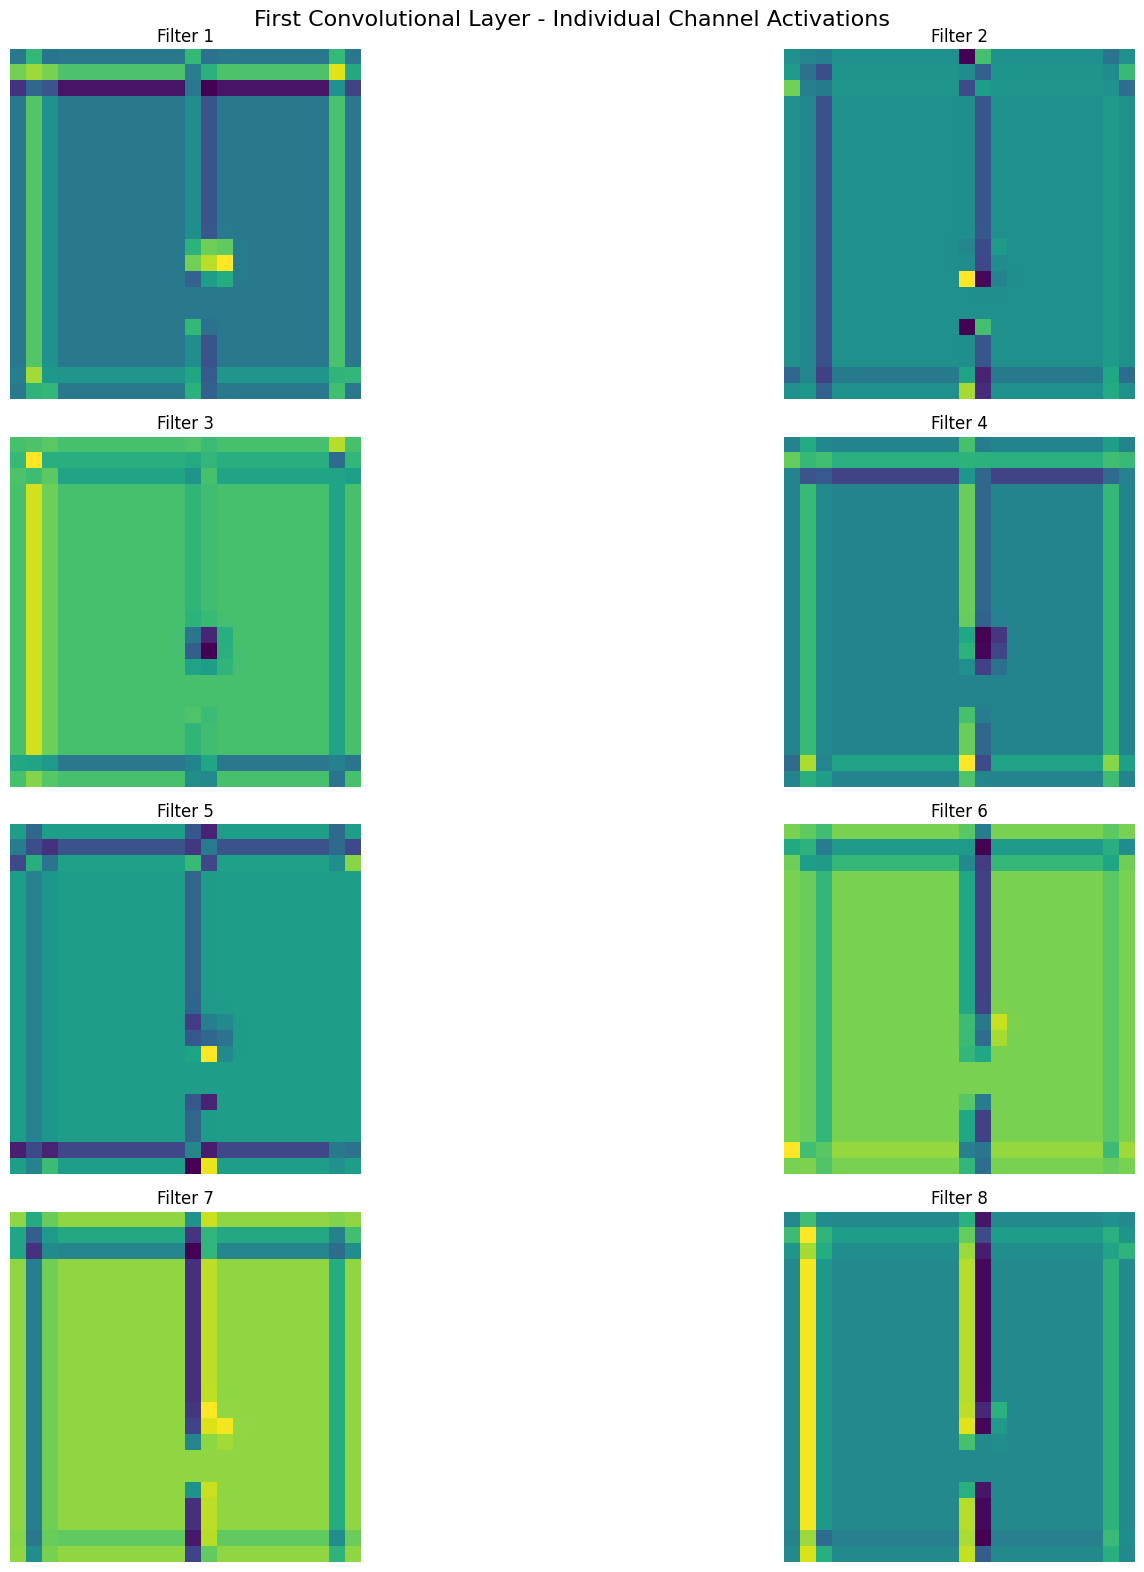

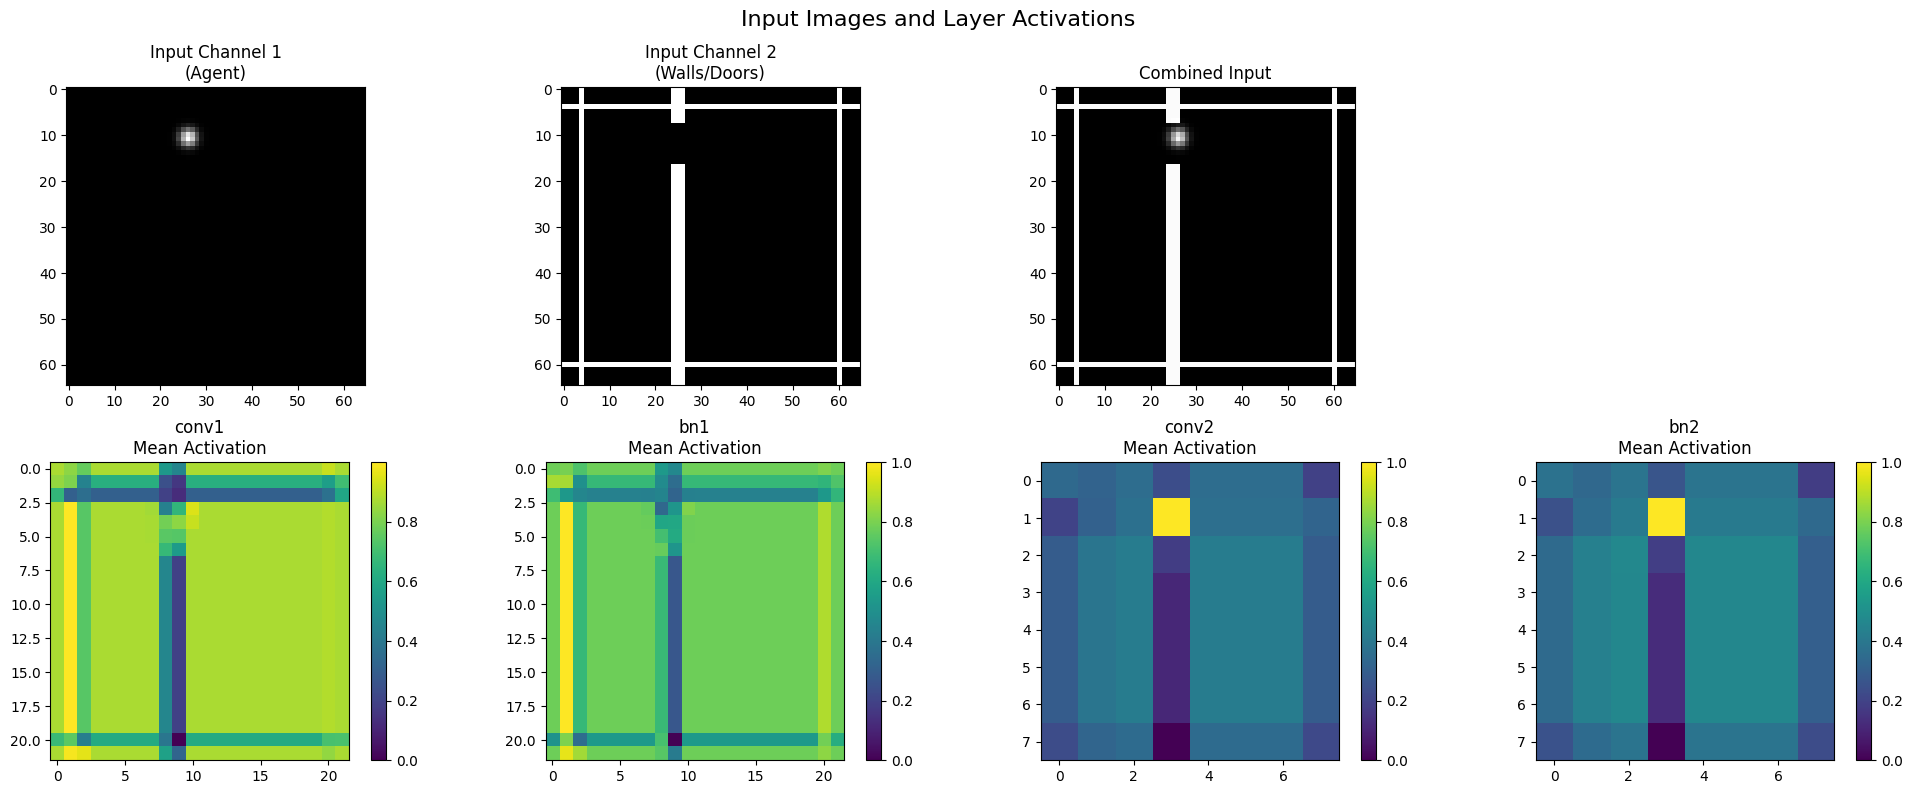

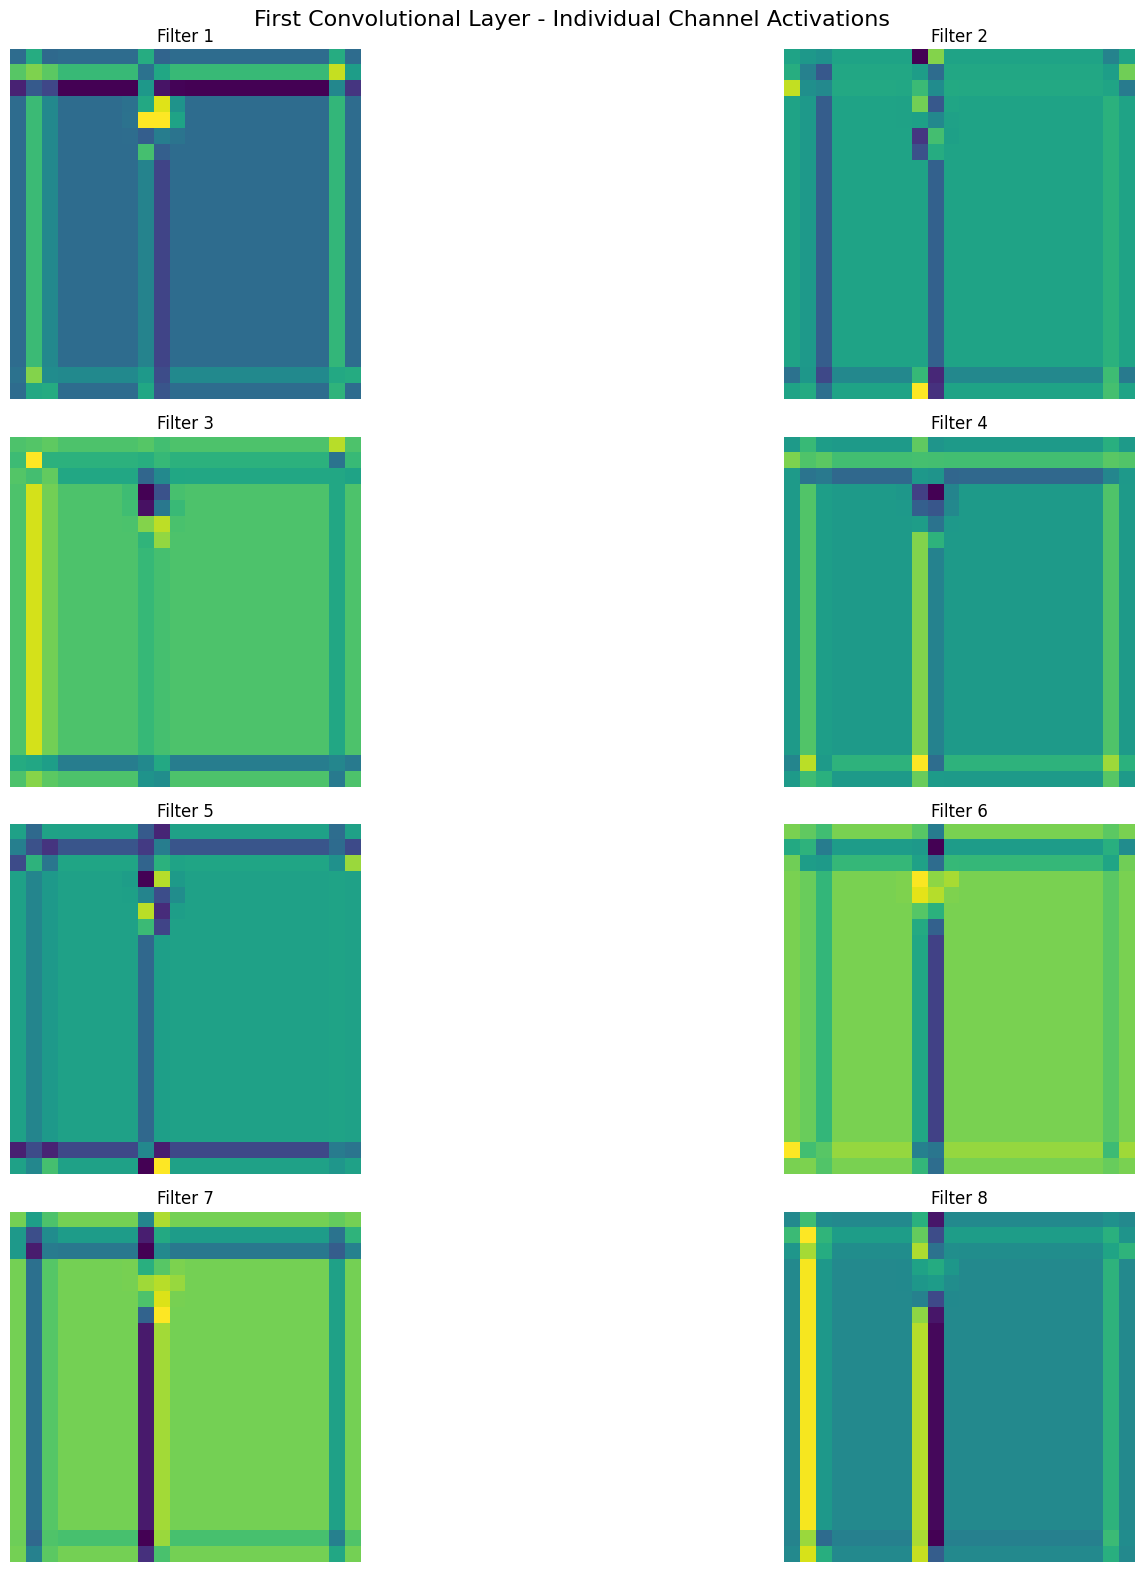

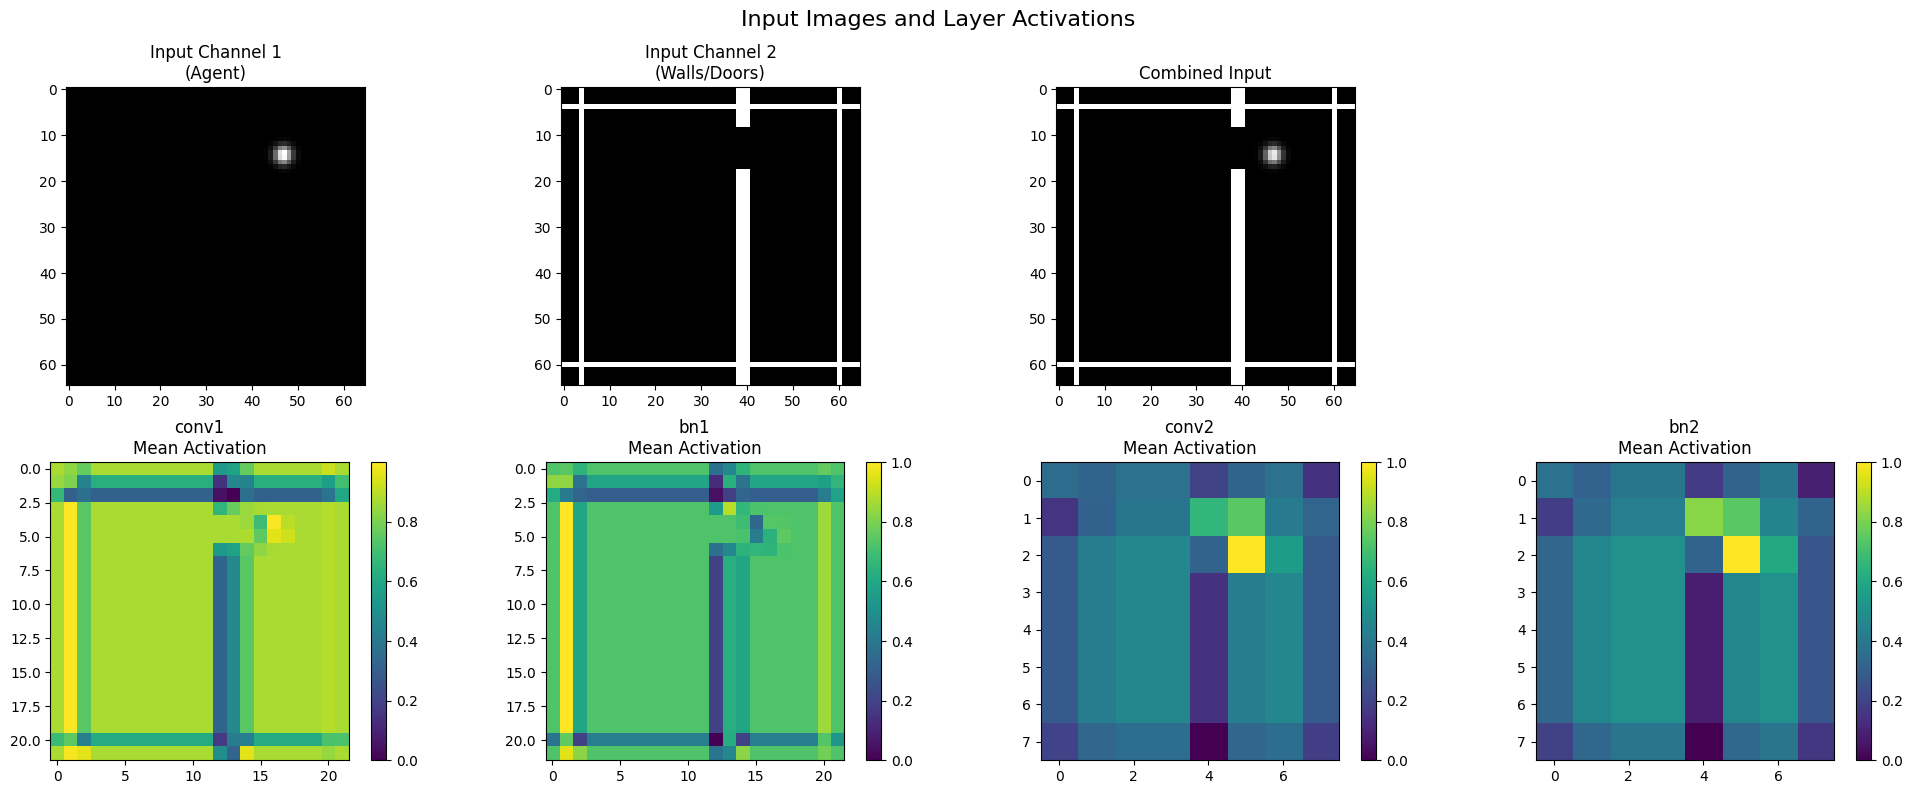

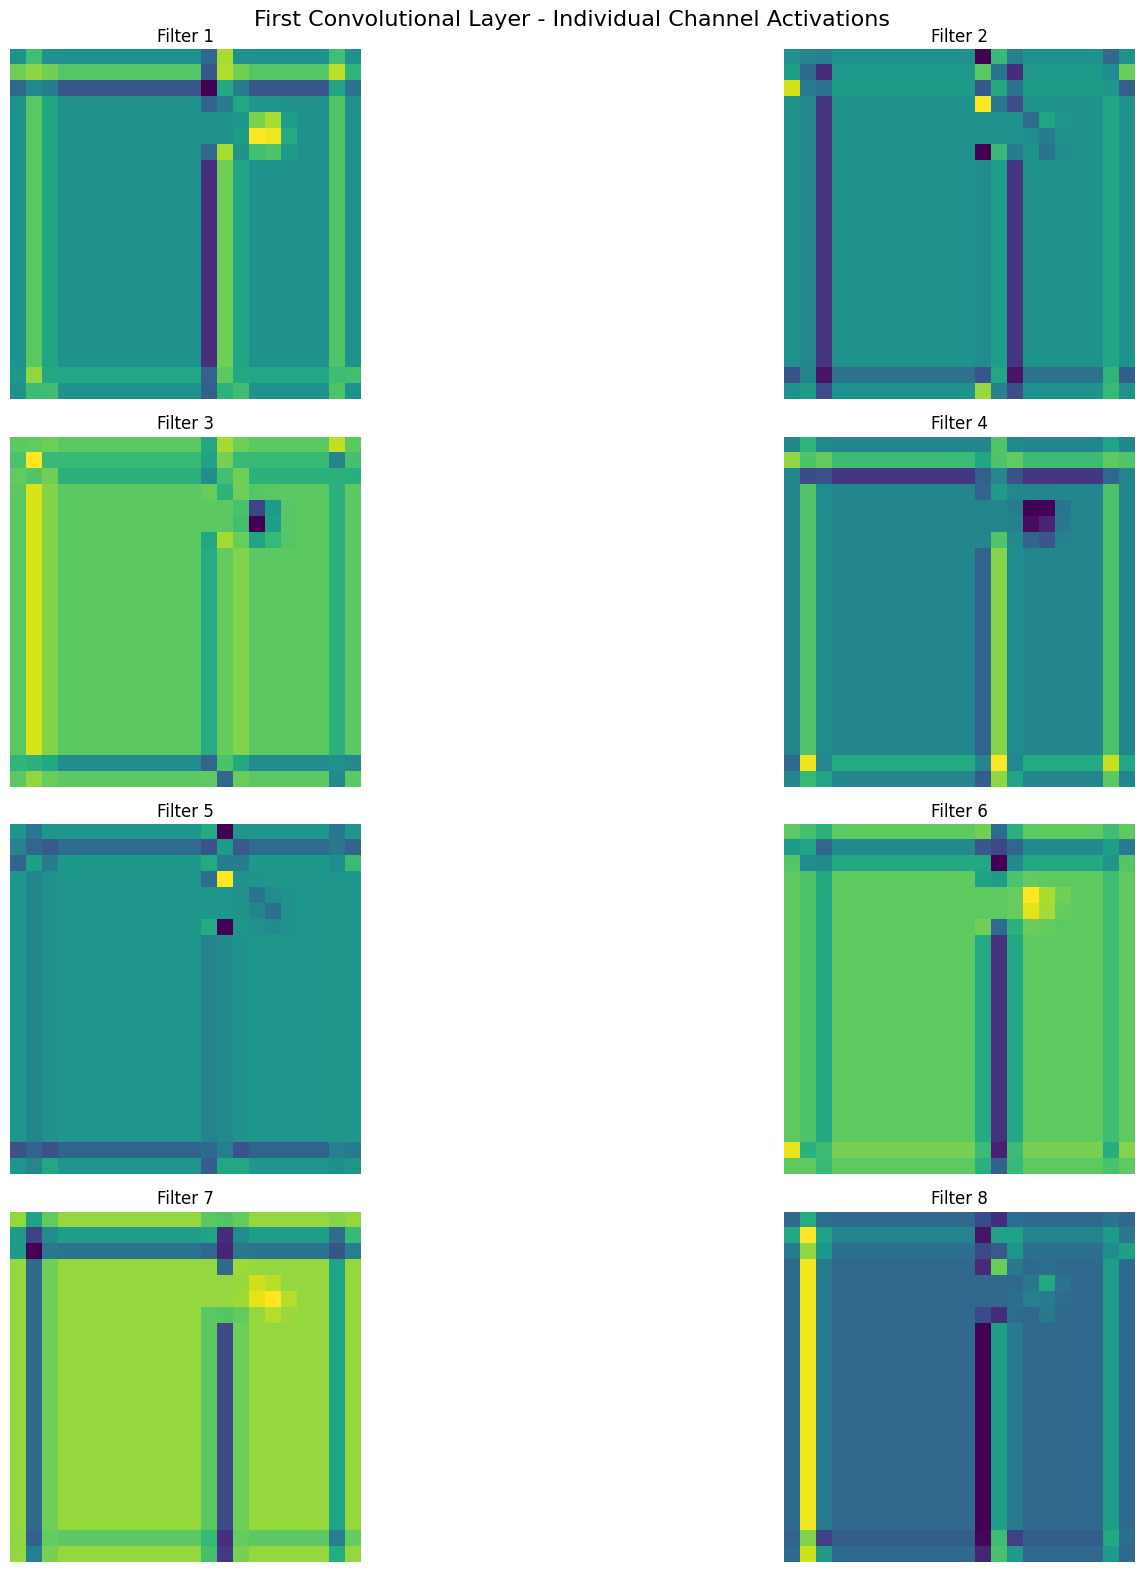


Saving trajectories...
Training prober...




be prediction step:   4%|█▊                                     | 7/156 [00:00<00:02, 63.53it/s]

normalized pred locations loss 0.9651095271110535

















e prediction step:  69%|█████████████████████████▍           | 107/156 [00:01<00:00, 70.11it/s]

normalized pred locations loss 0.030058030039072037







Probe prediction step: 100%|█████████████████████████████████████| 156/156 [00:02<00:00, 69.02it/s]









be prediction step:  37%|█████████████▉                        | 57/156 [00:00<00:01, 69.67it/s]

normalized pred locations loss 0.021581968292593956
















Probe prediction epochs:  10%|███▊                                  | 2/20 [00:04<00:40,  2.26s/it]

normalized pred locations loss 0.01699741557240486

















be prediction step:  64%|███████████████████████▋             | 100/156 [00:01<00:00, 69.18it/s]

normalized pred locations loss 0.020068056881427765










Probe prediction step: 100%|█████████████████████████████████████| 156/156 [00:02<00:00, 69.26it/s]







be prediction step:  27%|██████████▏                           | 42/156 [00:00<00:01, 69.24it/s]

normalized pred locations loss 0.013831312768161297
















be prediction step:  90%|█████████████████████████████████▍   | 141/156 [00:02<00:00, 68.26it/s]

normalized pred locations loss 0.013649064116179943




Probe prediction step: 100%|█████████████████████████████████████| 156/156 [00:02<00:00, 68.90it/s]













be prediction step:  54%|████████████████████▍                 | 84/156 [00:01<00:01, 69.11it/s]

normalized pred locations loss 0.011825828813016415












Probe prediction step: 100%|█████████████████████████████████████| 156/156 [00:02<00:00, 69.14it/s]





be prediction step:  18%|██████▊                               | 28/156 [00:00<00:01, 68.99it/s]

normalized pred locations loss 0.008954884484410286

















be prediction step:  86%|███████████████████████████████▊     | 134/156 [00:01<00:00, 68.95it/s]

normalized pred locations loss 0.014072903431952





Probe prediction step: 100%|█████████████████████████████████████| 156/156 [00:02<00:00, 69.13it/s]











be prediction step:  47%|██████████████████                    | 74/156 [00:01<00:01, 69.84it/s]

normalized pred locations loss 0.00889652967453003













Probe prediction step: 100%|█████████████████████████████████████| 156/156 [00:02<00:00, 69.40it/s]




be prediction step:  13%|█████                                 | 21/156 [00:00<00:01, 69.06it/s]

normalized pred locations loss 0.011003101244568825
















be prediction step:  77%|████████████████████████████▍        | 120/156 [00:01<00:00, 69.09it/s]

normalized pred locations loss 0.01157201174646616







Probe prediction step: 100%|█████████████████████████████████████| 156/156 [00:02<00:00, 69.10it/s]










be prediction step:  40%|███████████████▎                      | 63/156 [00:00<00:01, 68.99it/s]

normalized pred locations loss 0.00885800551623106















Probe prediction epochs:  45%|█████████████████                     | 9/20 [00:20<00:24,  2.26s/it]

normalized pred locations loss 0.009666488505899906


















be prediction step:  68%|█████████████████████████▏           | 106/156 [00:01<00:00, 69.05it/s]

normalized pred locations loss 0.0077335345558822155









Probe prediction step: 100%|█████████████████████████████████████| 156/156 [00:02<00:00, 69.11it/s]








be prediction step:  31%|███████████▉                          | 49/156 [00:00<00:01, 69.02it/s]

normalized pred locations loss 0.007691497448831797

















be prediction step:  99%|████████████████████████████████████▌| 154/156 [00:02<00:00, 68.79it/s]

normalized pred locations loss 0.011321530677378178


Probe prediction step: 100%|█████████████████████████████████████| 156/156 [00:02<00:00, 68.95it/s]















be prediction step:  63%|███████████████████████▊              | 98/156 [00:01<00:00, 69.12it/s]

normalized pred locations loss 0.008787770755589008










Probe prediction step: 100%|█████████████████████████████████████| 156/156 [00:02<00:00, 69.09it/s]







be prediction step:  27%|██████████▏                           | 42/156 [00:00<00:01, 69.15it/s]

normalized pred locations loss 0.006236494984477758
















be prediction step:  90%|█████████████████████████████████▏   | 140/156 [00:02<00:00, 69.10it/s]

normalized pred locations loss 0.00791604071855545




Probe prediction step: 100%|█████████████████████████████████████| 156/156 [00:02<00:00, 69.10it/s]













be prediction step:  54%|████████████████████▍                 | 84/156 [00:01<00:01, 68.48it/s]

normalized pred locations loss 0.005556690040975809












Probe prediction step: 100%|█████████████████████████████████████| 156/156 [00:02<00:00, 68.92it/s]





be prediction step:  18%|██████▊                               | 28/156 [00:00<00:01, 69.11it/s]

normalized pred locations loss 0.007777129765599966
















be prediction step:  81%|█████████████████████████████▉       | 126/156 [00:01<00:00, 69.07it/s]

normalized pred locations loss 0.008127653039991856






Probe prediction step: 100%|█████████████████████████████████████| 156/156 [00:02<00:00, 69.05it/s]











be prediction step:  46%|█████████████████▎                    | 71/156 [00:01<00:01, 69.05it/s]

normalized pred locations loss 0.005145862698554993














Probe prediction step: 100%|█████████████████████████████████████| 156/156 [00:02<00:00, 68.77it/s]



be prediction step:   9%|███▍                                  | 14/156 [00:00<00:02, 69.27it/s]

normalized pred locations loss 0.007701268885284662
















be prediction step:  72%|██████████████████████████▌          | 112/156 [00:01<00:00, 67.60it/s]

normalized pred locations loss 0.007759516593068838








Probe prediction step: 100%|█████████████████████████████████████| 156/156 [00:02<00:00, 67.40it/s]









be prediction step:  36%|█████████████▋                        | 56/156 [00:00<00:01, 67.55it/s]

normalized pred locations loss 0.006436736322939396
















Probe prediction epochs:  90%|█████████████████████████████████▎   | 18/20 [00:40<00:04,  2.29s/it]

normalized pred locations loss 0.007399311754852533


















be prediction step:  67%|████████████████████████▉            | 105/156 [00:01<00:00, 68.93it/s]

normalized pred locations loss 0.00448359502479434









Probe prediction step: 100%|█████████████████████████████████████| 156/156 [00:02<00:00, 68.39it/s]








be prediction step:  31%|███████████▉                          | 49/156 [00:00<00:01, 68.99it/s]

normalized pred locations loss 0.005998523440212011
















be prediction step:  95%|███████████████████████████████████  | 148/156 [00:02<00:00, 69.42it/s]

normalized pred locations loss 0.007447891402989626



Probe prediction step: 100%|█████████████████████████████████████| 156/156 [00:02<00:00, 69.01it/s]

robe prediction epochs: 100%|█████████████████████████████████████| 20/20 [00:45<00:00,  2.27s/it]

Prober training complete!
Processing normal dataset...



etting predictions:   6%|██▋                                       | 4/62 [00:00<00:01, 31.38it/s]

Processing wall dataset...



etting predictions:   6%|██▋                                       | 4/62 [00:00<00:01, 30.89it/s]

Processing wall_other dataset...



etting predictions:   6%|██▋                                       | 4/62 [00:00<00:01, 31.04it/s]


All visualizations saved in 'visualization_outputs' directory!


In [13]:
import os
from matplotlib.patches import Circle
from matplotlib.collections import LineCollection
import matplotlib.colors as mcolors

def setup_output_dirs():
    """Create organized directory structure for outputs"""
    base_dir = "visualization_outputs"
    dirs = {
        'filters': os.path.join(base_dir, 'conv_filters'),
        'activations': os.path.join(base_dir, 'activations'),
        'trajectories': os.path.join(base_dir, 'trajectories'),
    }
    
    for dir_path in dirs.values():
        os.makedirs(dir_path, exist_ok=True)
    
    return dirs

def visualize_trajectory_combined(states, true_locations, pred_locations, save_path=None, sample_idx=0):
    """Visualize all timesteps of a trajectory in a single plot"""
    # Get data for the specified sample
    state = states[sample_idx]  # Shape: [T, 2, H, W]
    true_pos = true_locations[sample_idx]  # Shape: [T, 2]
    pred_pos = pred_locations[sample_idx]  # Shape: [T, 2]
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Plot environment (use the first timestep's walls as they don't change)
    wall_img = state[0, 1].cpu()
    ax.imshow(wall_img, cmap='gray', alpha=0.5)
    
    # Colors for trajectories
    true_color = 'blue'
    pred_color = 'red'
    n_timesteps = len(true_pos)
    
    # Create gradient colors for the trajectories
    true_colors = [mcolors.to_rgba(true_color, alpha=0.3 + 0.7 * i/n_timesteps) 
                  for i in range(n_timesteps)]
    pred_colors = [mcolors.to_rgba(pred_color, alpha=0.3 + 0.7 * i/n_timesteps) 
                  for i in range(n_timesteps)]
    
    # Plot trajectories with lines connecting points
    for i in range(n_timesteps - 1):
        # True trajectory lines
        ax.plot(true_pos[i:i+2, 0], true_pos[i:i+2, 1], 
                color=true_colors[i], linewidth=2, zorder=1)
        
        # Predicted trajectory lines
        ax.plot(pred_pos[i:i+2, 0], pred_pos[i:i+2, 1], 
                color=pred_colors[i], linewidth=2, zorder=1)
    
    # Plot points with increasing size for time dimension
    sizes = np.linspace(50, 200, n_timesteps)
    
    # Plot all points with transparency
    for i in range(n_timesteps):
        # True positions
        ax.scatter(true_pos[i, 0], true_pos[i, 1], 
                  c=[true_colors[i]], s=sizes[i], 
                  label='True' if i == 0 else "", zorder=2)
        
        # Predicted positions
        ax.scatter(pred_pos[i, 0], pred_pos[i, 1], 
                  c=[pred_colors[i]], s=sizes[i], 
                  label='Predicted' if i == 0 else "", zorder=2)
    
    # Highlight initial points
    ax.scatter(true_pos[0, 0], true_pos[0, 1], c='blue', s=300, 
              edgecolor='white', linewidth=2, label='True Start', zorder=3)
    ax.scatter(pred_pos[0, 0], pred_pos[0, 1], c='red', s=300, 
              edgecolor='white', linewidth=2, label='Predicted Start', zorder=3)
    
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_title('Complete Trajectory\n(Larger markers indicate later timesteps)')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        plt.close()
    else:
        plt.show()

# Modified visualization code for saving
def save_visualizations(model, datasets, output_dirs):
    """Save all visualizations in organized folders"""
    
    # 1. Save Conv Filters
    print("Saving convolutional filters...")
    for layer_idx in range(2):
        plt.figure()
        visualize_conv_filters(model, layer_idx)
        plt.savefig(os.path.join(output_dirs['filters'], f'conv_filters_layer{layer_idx+1}.png'),
                   bbox_inches='tight', dpi=300)
        plt.close()
    
    # 2. Save Activations
    print("\nSaving activation maps...")
    dataset = datasets['normal']
    batch = next(iter(dataset))
    for i in range(3):
        visualize_input_and_activations(model, batch, sample_idx=i)
        plt.savefig(os.path.join(output_dirs['activations'], f'activations_sample{i+1}.png'),
                   bbox_inches='tight', dpi=300)
        plt.close()
    
    # 3. Save Trajectories
    print("\nSaving trajectories...")
    prober, evaluator = train_and_get_prober()
    
    for dataset_name, dataset in datasets.items():
        if dataset_name == 'probe_train':
            continue
            
        print(f"Processing {dataset_name} dataset...")
        states, true_positions, pred_positions = get_predictions(dataset, prober, evaluator)
        
        # Save multiple samples
        for i in range(min(5, len(states))):
            save_path = os.path.join(output_dirs['trajectories'], 
                                   f'trajectory_{dataset_name}_sample{i+1}.png')
            visualize_trajectory_combined(states, true_positions, pred_positions, 
                                       save_path=save_path, sample_idx=i)

# Main execution
output_dirs = setup_output_dirs()
print("Starting visualization generation...")
save_visualizations(model, datasets, output_dirs)
print("\nAll visualizations saved in 'visualization_outputs' directory!")

In [14]:
from torch.autograd import grad
import torch.nn.functional as F

def compute_saliency_maps(model, batch, sample_idx=0):
    """Compute saliency maps for a given input"""
    # Get single sample input
    input_state = batch.states[sample_idx:sample_idx+1, 0:1].clone().requires_grad_(True)
    target_actions = batch.actions[sample_idx:sample_idx+1]
    
    # Forward pass
    model.zero_grad()
    predictions = model(states=input_state, actions=target_actions)
    
    # Compute gradients with respect to input
    # Sum across all predicted dimensions to get scalar output
    predictions.sum().backward()
    
    # Get gradients
    saliency = input_state.grad.abs()
    
    return saliency[0, 0], input_state[0, 0]  # Return first timestep only

def visualize_saliency(model, batch, save_dir, sample_idx=0):
    """Visualize saliency maps alongside input"""
    saliency, input_state = compute_saliency_maps(model, batch, sample_idx)
    
    # Convert to numpy for visualization
    saliency = saliency.cpu().numpy()
    input_state = input_state.detach().cpu().numpy()
    
    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    
    # Original input channels
    axes[0, 0].imshow(input_state[0], cmap='gray')
    axes[0, 0].set_title('Input - Agent Channel')
    axes[0, 1].imshow(input_state[1], cmap='gray')
    axes[0, 1].set_title('Input - Wall Channel')
    
    # Combined input
    combined = input_state[0] + input_state[1]
    axes[1, 0].imshow(combined, cmap='gray')
    axes[1, 0].set_title('Combined Input')
    
    # Saliency map
    saliency_avg = saliency.mean(axis=0)  # Average across channels
    saliency_normalized = (saliency_avg - saliency_avg.min()) / (saliency_avg.max() - saliency_avg.min() + 1e-8)
    im = axes[1, 1].imshow(saliency_normalized, cmap='hot')
    axes[1, 1].set_title('Saliency Map')
    plt.colorbar(im, ax=axes[1, 1])
    
    plt.suptitle('Input and Saliency Map Analysis', size=16)
    plt.tight_layout()
    
    # Save the figure
    save_path = os.path.join(save_dir, f'saliency_sample{sample_idx+1}.png')
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.close()
    
    return saliency_normalized

def compute_integrated_gradients(model, batch, sample_idx=0, steps=50):
    """Compute integrated gradients for better attribution"""
    # Get single sample input
    input_state = batch.states[sample_idx:sample_idx+1, 0:1].clone()
    target_actions = batch.actions[sample_idx:sample_idx+1]
    
    # Create path from zero to input
    alphas = torch.linspace(0, 1, steps).cuda()
    scaled_inputs = input_state * alphas.view(-1, 1, 1, 1, 1)
    
    integrated_grads = torch.zeros_like(input_state)
    
    for scaled_input in scaled_inputs:
        scaled_input.requires_grad_(True)
        
        # Forward pass
        model.zero_grad()
        predictions = model(states=scaled_input.unsqueeze(0), actions=target_actions)
        
        # Backward pass
        predictions.sum().backward()
        
        # Accumulate gradients
        integrated_grads += scaled_input.grad
    
    # Average gradients and multiply by input
    integrated_grads *= input_state / steps
    
    return integrated_grads[0, 0], input_state[0, 0]

def visualize_integrated_gradients(model, batch, save_dir, sample_idx=0):
    """Visualize integrated gradients alongside input"""
    integrated_grads, input_state = compute_integrated_gradients(model, batch, sample_idx)
    
    # Convert to numpy
    integrated_grads = integrated_grads.cpu().numpy()
    input_state = input_state.detach().cpu().numpy()
    
    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    
    # Original input
    axes[0, 0].imshow(input_state[0], cmap='gray')
    axes[0, 0].set_title('Input - Agent Channel')
    axes[0, 1].imshow(input_state[1], cmap='gray')
    axes[0, 1].set_title('Input - Wall Channel')
    
    # Integrated gradients - separate channels
    ig_normalized = np.abs(integrated_grads)
    ig_normalized = (ig_normalized - ig_normalized.min()) / (ig_normalized.max() - ig_normalized.min() + 1e-8)
    
    # Combined visualization
    combined_input = input_state[0] + input_state[1]
    axes[1, 0].imshow(combined_input, cmap='gray')
    axes[1, 0].set_title('Combined Input')
    
    # Integrated gradients overlay
    im = axes[1, 1].imshow(ig_normalized.mean(axis=0), cmap='hot')
    axes[1, 1].set_title('Integrated Gradients')
    plt.colorbar(im, ax=axes[1, 1])
    
    plt.suptitle('Input and Integrated Gradients Analysis', size=16)
    plt.tight_layout()
    
    # Save the figure
    save_path = os.path.join(save_dir, f'integrated_gradients_sample{sample_idx+1}.png')
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.close()
    
    return ig_normalized

# Update setup_output_dirs function
def setup_output_dirs():
    """Create organized directory structure for outputs"""
    base_dir = "visualization_outputs"
    dirs = {
        'filters': os.path.join(base_dir, 'conv_filters'),
        'activations': os.path.join(base_dir, 'activations'),
        'trajectories': os.path.join(base_dir, 'trajectories'),
        'saliency': os.path.join(base_dir, 'saliency'),  # New directory
    }
    
    for dir_path in dirs.values():
        os.makedirs(dir_path, exist_ok=True)
    
    return dirs

# Update save_visualizations function
def save_visualizations(model, datasets, output_dirs):
    """Save all visualizations in organized folders"""
    # ... (previous visualization code remains the same)
    
    # 4. Save Saliency Maps
    print("\nSaving saliency maps...")
    for dataset_name, dataset in datasets.items():
        if dataset_name == 'probe_train':
            continue
            
        print(f"Processing saliency maps for {dataset_name} dataset...")
        batch = next(iter(dataset))
        
        # Save for multiple samples
        for i in range(3):
            # Regular saliency maps
            visualize_saliency(model, batch, 
                             save_dir=output_dirs['saliency'], 
                             sample_idx=i)
            
            # Integrated gradients
            visualize_integrated_gradients(model, batch, 
                                        save_dir=output_dirs['saliency'], 
                                        sample_idx=i)

# Main execution remains the same
output_dirs = setup_output_dirs()
print("Starting visualization generation...")
save_visualizations(model, datasets, output_dirs)
print("\nAll visualizations saved in 'visualization_outputs' directory!")

Starting visualization generation...

Saving saliency maps...
Processing saliency maps for normal dataset...
Processing saliency maps for wall dataset...
Processing saliency maps for wall_other dataset...

All visualizations saved in 'visualization_outputs' directory!


In [15]:
def apply_temperature_scaling(attribution_map, temperature=0.25):
    """Apply temperature scaling to make distribution spikier"""
    # Convert to torch tensor for numerical stability
    x = torch.tensor(attribution_map)
    
    # Normalize to [0, 1]
    x = (x - x.min()) / (x.max() - x.min() + 1e-8)
    
    # Apply temperature scaling
    x = torch.pow(x, 1/temperature)
    
    # Normalize again
    x = (x - x.min()) / (x.max() - x.min() + 1e-8)
    
    return x.numpy()

def visualize_saliency(model, batch, save_dir, sample_idx=0, temperature=0.25, dataset_name="unknown"):
    """Visualize saliency maps alongside input with temperature scaling"""
    saliency, input_state = compute_saliency_maps(model, batch, sample_idx)
    
    # Convert to numpy
    saliency = saliency.cpu().numpy()
    input_state = input_state.detach().cpu().numpy()
    
    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    
    # Original input channels
    axes[0, 0].imshow(input_state[0], cmap='gray')
    axes[0, 0].set_title('Input - Agent Channel')
    axes[0, 1].imshow(input_state[1], cmap='gray')
    axes[0, 1].set_title('Input - Wall Channel')
    
    # Combined input
    combined = input_state[0] + input_state[1]
    axes[1, 0].imshow(combined, cmap='gray')
    axes[1, 0].set_title('Combined Input')
    
    # Saliency map with temperature scaling
    saliency_avg = saliency.mean(axis=0)
    saliency_scaled = apply_temperature_scaling(saliency_avg, temperature)
    
    # Use 'inferno' colormap for better contrast
    im = axes[1, 1].imshow(saliency_scaled, cmap='inferno')
    axes[1, 1].set_title(f'Saliency Map (T={temperature})')
    plt.colorbar(im, ax=axes[1, 1])
    
    plt.suptitle(f'Input and Saliency Map Analysis - {dataset_name}', size=16)
    plt.tight_layout()
    
    # Save the figure
    save_path = os.path.join(save_dir, f'saliency_{dataset_name}_sample{sample_idx+1}.png')
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.close()
    
    return saliency_scaled

def visualize_integrated_gradients(model, batch, save_dir, sample_idx=0, temperature=0.25, dataset_name="unknown"):
    """Visualize integrated gradients with temperature scaling"""
    integrated_grads, input_state = compute_integrated_gradients(model, batch, sample_idx)
    
    # Convert to numpy
    integrated_grads = integrated_grads.cpu().numpy()
    input_state = input_state.detach().cpu().numpy()
    
    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    
    # Original input
    axes[0, 0].imshow(input_state[0], cmap='gray')
    axes[0, 0].set_title('Input - Agent Channel')
    axes[0, 1].imshow(input_state[1], cmap='gray')
    axes[0, 1].set_title('Input - Wall Channel')
    
    # Integrated gradients - apply temperature scaling
    ig_normalized = np.abs(integrated_grads)
    ig_normalized = ig_normalized.mean(axis=0)
    ig_scaled = apply_temperature_scaling(ig_normalized, temperature)
    
    # Combined visualization
    combined_input = input_state[0] + input_state[1]
    axes[1, 0].imshow(combined_input, cmap='gray')
    axes[1, 0].set_title('Combined Input')
    
    # Integrated gradients overlay
    im = axes[1, 1].imshow(ig_scaled, cmap='inferno')
    axes[1, 1].set_title(f'Integrated Gradients (T={temperature})')
    plt.colorbar(im, ax=axes[1, 1])
    
    plt.suptitle(f'Input and Integrated Gradients Analysis - {dataset_name}', size=16)
    plt.tight_layout()
    
    # Save the figure
    save_path = os.path.join(save_dir, f'integrated_gradients_{dataset_name}_sample{sample_idx+1}.png')
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.close()
    
    return ig_scaled

In [21]:
def apply_temperature_scaling(attribution_map, temperature=0.8):
    """Apply temperature scaling to make distribution spikier"""
    x = torch.tensor(attribution_map)
    x = (x - x.min()) / (x.max() - x.min() + 1e-8)
    x = torch.pow(x, 1/temperature)
    x = (x - x.min()) / (x.max() - x.min() + 1e-8)
    return x.numpy()

def visualize_saliency(model, batch, save_dir, sample_idx=0, temperature=0.25, dataset_name="unknown"):
    """Visualize saliency maps alongside input with temperature scaling"""
    saliency, input_state = compute_saliency_maps(model, batch, sample_idx)
    
    saliency = saliency.cpu().numpy()
    input_state = input_state.detach().cpu().numpy()
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    
    axes[0, 0].imshow(input_state[0], cmap='gray')
    axes[0, 0].set_title('Input - Agent Channel')
    axes[0, 1].imshow(input_state[1], cmap='gray')
    axes[0, 1].set_title('Input - Wall Channel')
    
    combined = input_state[0] + input_state[1]
    axes[1, 0].imshow(combined, cmap='gray')
    axes[1, 0].set_title('Combined Input')
    
    saliency_avg = saliency.mean(axis=0)
    saliency_scaled = apply_temperature_scaling(saliency_avg, temperature)
    
    im = axes[1, 1].imshow(saliency_scaled, cmap='inferno')
    axes[1, 1].set_title(f'Saliency Map (T={temperature})')
    plt.colorbar(im, ax=axes[1, 1])
    
    plt.suptitle(f'Input and Saliency Map Analysis - {dataset_name}', size=16)
    plt.tight_layout()
    
    save_path = os.path.join(save_dir, f'saliency_{dataset_name}_sample{sample_idx+1}.png')
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.close()
    
    return saliency_scaled

def visualize_integrated_gradients(model, batch, save_dir, sample_idx=0, temperature=0.25, dataset_name="unknown"):
    """Visualize integrated gradients with temperature scaling"""
    integrated_grads, input_state = compute_integrated_gradients(model, batch, sample_idx)
    
    integrated_grads = integrated_grads.cpu().numpy()
    input_state = input_state.detach().cpu().numpy()
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    
    axes[0, 0].imshow(input_state[0], cmap='gray')
    axes[0, 0].set_title('Input - Agent Channel')
    axes[0, 1].imshow(input_state[1], cmap='gray')
    axes[0, 1].set_title('Input - Wall Channel')
    
    ig_normalized = np.abs(integrated_grads)
    ig_normalized = ig_normalized.mean(axis=0)
    ig_scaled = apply_temperature_scaling(ig_normalized, temperature)
    
    combined_input = input_state[0] + input_state[1]
    axes[1, 0].imshow(combined_input, cmap='gray')
    axes[1, 0].set_title('Combined Input')
    
    im = axes[1, 1].imshow(ig_scaled, cmap='inferno')
    axes[1, 1].set_title(f'Integrated Gradients (T={temperature})')
    plt.colorbar(im, ax=axes[1, 1])
    
    plt.suptitle(f'Input and Integrated Gradients Analysis - {dataset_name}', size=16)
    plt.tight_layout()
    
    save_path = os.path.join(save_dir, f'integrated_gradients_{dataset_name}_sample{sample_idx+1}.png')
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.close()
    
    return ig_scaled

def save_visualizations(model, datasets, output_dirs):
    """Save all visualizations in organized folders"""
    # Previous visualization code for filters, activations, trajectories...
    
    # Saliency Maps
    print("\nSaving saliency maps...")
    temperatures = [1]
    
    for dataset_name, dataset in datasets.items():
        if dataset_name == 'probe_train':
            continue
            
        print(f"Processing saliency maps for {dataset_name} dataset...")
        
        n_batches = 3
        n_samples_per_batch = 5
        
        for batch_idx, batch in enumerate(dataset):
            if batch_idx >= n_batches:
                break
                
            for temp in temperatures:
                for i in range(n_samples_per_batch):
                    visualize_saliency(
                        model, batch,
                        save_dir=output_dirs['saliency'],
                        sample_idx=i,
                        temperature=temp,
                        dataset_name=f"{dataset_name}_temp{temp}_batch{batch_idx+1}"
                    )
                    
                    visualize_integrated_gradients(
                        model, batch,
                        save_dir=output_dirs['saliency'],
                        sample_idx=i,
                        temperature=temp,
                        dataset_name=f"{dataset_name}_temp{temp}_batch{batch_idx+1}"
                    )

# Main execution
output_dirs = setup_output_dirs()
print("Starting visualization generation...")
save_visualizations(model, datasets, output_dirs)
print("\nAll visualizations saved in 'visualization_outputs' directory!")

Starting visualization generation...

Saving saliency maps...
Processing saliency maps for normal dataset...
Processing saliency maps for wall dataset...
Processing saliency maps for wall_other dataset...

All visualizations saved in 'visualization_outputs' directory!
